#### _"Данные важнее алгоритмов"_

### Проект 5 "Компьютер говорит «Нет»".
**Цель проекта**: построение скоринговой модели машинного обучения для предсказания вероятности дефолта по кредиту у клиента.

Проект представляет собой учебную версию скоринговой проблемы, которая является одной из типичных в банковском секторе. В рамках проекта должна быть решена задача бинарной классификации, в которой в качестве положительного класса выбран дефолт заёмщика по кредиту. Полученная в результате решения задачи модель машинного обучения должна как можно лучше классифицировать клиентов на "плохих" (высокая вероятность дефолта) и "хороших" (низкая вероятность дефолта).

Для достижения поставленной цели необходимо решить ряд задач. Последовательность этого решения имеет следующий план.
>1. Знакомство с данными.  

>2. Разведочный анализ данных (EDA), преобразование (Feature Engineering) и отбор признаков (Feature Selection).  

>3. Обучение модели-классификатора.  

>4. Анализ результатов. Выводы.  

Краткое оптсание пунктов плана.  
>1. Знакомство с данными.

В этом разделе происходит загрузка данных, ознакомление со структурой данных (количество объектов-клиентов, количество признаков). Констатируется наличие или отсутствие пропусков у тех или иных признаков. Осуществляется проверка на уникальность объектов (наличие или отсутствие дубликатов). Выясняется тип признаков (числовой или категориальный), их масштабы изменения, размерность. Осуществляется первичный анализ признаков с помощью визуализации и отдельных таблиц, определяется наличие или отсутствие явных противоречий в данных.

>2. Разведочный анализ данных (EDA), преобразование (Feature Engineering) и отбор признаков (Feature Selection).

В пункте 2 данные подвергаются необходимой трансформации, например, нечисловые признаки преобразуются в числовые. Осуществляется обработка пропусков данных. При необходимости происходит "выравнивание" эмпирической функции распределения числовых признаков, т.е. приближение этой функции к нормальной функции распределения. Как правило, для этого используются монотонные преобразования типа логарифмирования, взятия корня и т.п. Далее признаки подвергаются нормализации. **Важно!** В пункте 2 создаётся так называемая наивная, или базовая, модель классификации, с помощью которой оценивается эффективность преобразования признаков. Признаки подвергаются селекции, определяется значимость признаков, их влияние на целевую переменную.

>3. Обучение модели-классификатора.

Осуществляется выбор окончательной модели (или моделей) классификации. По условиям задания на проект, необходимо по возможности использовать при выборе и обучении модели - технику подбора оптимальных значений гиперпараметров. Важным аспектом в данном пункте плана является вычисление моделью различных метрик качества классификации.

>4. Анализ результатов. Выводы.

В заключительном разделе плана анализируются результаты, полученные в ходе выбора и обучения окончательной модели-классификатора. Анализ осуществляется над полученными метриками классификации, насколько сбалансированными являются значения этих метрик, чтобы можно было констатировать факт достижения поставленной цели проекта. Иначе говоря, насколько полно построенная модель классификации охватывает политику банка в части кредитования - рискованной (получение дополнительного дохода за счёт снижения порога ожидаемой "дефолтности" клиента) или консервативной (снижение издержек вследствие усиления требований к "хорошему" заёмщику). Делаются соответствующие выводы.
***
В данной - первой - части проекта реализован пункт 1. Знакомство с данными.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import seaborn as sns
from scipy.stats import kurtosis, skew, ks_2samp
from scipy import stats

#### Пользовательские функции и установки.

In [2]:
#------------------------------------------------------------------------------#
# Изменение установок по умолчанию для графиков:
def set_rc_params():
    plt.rcParams.update({
        "axes.facecolor"       : "LightYellow",
        "axes.labelsize"       : 14,
        "axes.titlesize"       : 16,
        "axes.grid"            : True,
        "axes.grid.axis"       : "both",
        "grid.linestyle"       : "dotted",
        "grid.alpha"           : 0.75,
        "legend.facecolor"     : "Lavender",
        "legend.shadow"        : True,
        "legend.fontsize"      : 12,
        "legend.edgecolor"     : "black",
        "legend.title_fontsize": 12,
        "figure.facecolor"     : "Lavender",
        "xtick.labelsize"      : 12,
        "ytick.labelsize"      : 12,
        "font.size"            : 16
    })

# Восстановление установок графиков по умолчанию. На всякий случай.
def set_rc_default():
    plt.rcdefaults()

#------------------------------------------------------------------------------#
# Переопределяем графические настройки:
set_rc_params()

#------------------------------------------------------------------------------#
def get_simple_graph(df, col, cat_order=[]):
    """
    Строит два графика для категориального признака и две итоговые таблицы.
    На входе:
        df - датафрейм
        col - имя признака
        cat_order - список из категорий признака (в желаемом порядке),
                    если список пустой, он заполняется внутри функции.
    На выходе:
        два графика на одном полотне
        две таблицы df_tot, df_trg (df_trg - только для данных 'train',
                                    для которых известная целевая переменная)
    """
    if len(cat_order) == 0:
        cat_order = df[col].unique().tolist()
# Общее распределение клиентов по признаку col (таблица df_tot):
    df_tot = pd.DataFrame(df[col].value_counts())
    df_tot = df_tot.loc[cat_order]
    df_tot['percentage'] = (df_tot[col] * 100 / df.shape[0]).round(1)
    df_tot = df_tot.reset_index()
    df_tot.columns = ['type', 'count', 'percentage']
# С учётом целевого признака (таблица df_trg - только для train):
    df_trg = df[df.flag=='train'].pivot_table(index=col, columns='default',
                        values='client_id', aggfunc='count')
    df_trg.columns = ['default_no', 'default_yes']
    df_trg['no : yes'] = (df_trg.default_no /  df_trg.default_yes).round(1)
    df_trg['yes, % no'] = (df_trg.default_yes * 100 / df_trg.default_no).round(1)
    df_trg = df_trg.loc[cat_order]
#---
    num = df[col].nunique()
    fig, ax = plt.subplots(1, 2, figsize=(22, 1.2*num))
    fig.subplots_adjust(wspace=0.075)
#------------------------------------------------------------------------------#
    sns.barplot(data=df_tot, x="count", y="type", palette="tab10", ax=ax[0])
#---
    ax[0].set_title(f'Признак {col}: общее распределение клиентов',
                fontweight='bold', style='italic')
    for k, val in enumerate(df_tot["count"].values):
        d = 0.01 * val
        ax[0].text(val+d, k, str(val), color='blue', fontsize=12,
                   fontweight='bold', ha="left", va="center")
#------------------------------------------------------------------------------#
    p100 = [100 for _ in range(num)]
    sns.barplot(data=df_trg, x=p100, y=df_trg.index, palette="tab10", alpha=0.5,
            ax=ax[1])
    sns.barplot(data=df_trg, x="yes, % no", y=df_trg.index, palette="tab10", 
            ax=ax[1])
#---
    ax[1].set_title(f'Признак {col}: доля "плохих" клиентов в % от "хороших"',
                fontweight='bold', style='italic')
    for k, val in enumerate(df_trg["yes, % no"].values):
        d = 0.01 * val
        ax[1].text(val+d, k, f'{val}%', color='blue', fontsize=12,
               fontweight='bold', ha="left", va="center")
    ax[1].set_xlabel('percentage (только для данных train)')
    [axx.grid("both") for axx in ax]; [axx.set_ylabel("") for axx in ax]
    
    return df_tot, df_trg
#------------------------------------------------------------------------------#

### 1. Знакомство с данными.
*`Знакомьтесь. Пудинг, это - Алиса. Алиса, это - Пудинг.`*

In [3]:
#------------------------------------------------------------------------------#
data_train = pd.read_csv('train.csv')
data_test = pd.read_csv('test.csv')
# Добавляем идентификатор:
data_train['flag'] = 'train'
data_test['flag'] = 'test'
# В таблице 'test' нет целевого признака.
# Добавим его с заведомо неправильным значением:
data_test['default'] = -100
# Склеиваем:
data = pd.concat([data_train, data_test], ignore_index=True)
data

,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,default,flag
0,25905,01FEB2014,SCH,M,62,Y,Y,0,0,-2.008753,1,50,1,2,18000,4,1,N,0,train
1,63161,12MAR2014,SCH,F,59,N,N,0,0,-1.532276,3,50,2,3,19000,4,1,N,0,train
2,25887,01FEB2014,SCH,M,25,Y,N,2,0,-1.408142,1,80,1,2,30000,1,4,Y,0,train
3,16222,23JAN2014,SCH,F,53,N,N,0,0,-2.057471,2,50,2,3,10000,1,3,N,0,train
4,101655,18APR2014,GRD,M,48,N,N,0,1,-1.244723,1,60,2,3,30000,1,4,Y,0,train
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
110143,83775,31MAR2014,SCH,F,37,N,N,1,0,-1.744976,3,50,2,3,15000,4,1,N,-100,test
110144,106254,25APR2014,GRD,F,64,Y,Y,0,0,-2.293781,3,60,1,2,200000,1,4,N,-100,test
110145,81852,30MAR2014,GRD,M,31,N,N,2,0,-0.940752,1,50,1,2,60000,4,2,N,-100,test
110146,1971,07JAN2014,UGR,F,27,N,N,1,0,-1.242392,2,80,2,3,30000,1,1,N,-100,test


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110148 entries, 0 to 110147
Data columns (total 20 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   client_id         110148 non-null  int64  
 1   app_date          110148 non-null  object 
 2   education         109670 non-null  object 
 3   sex               110148 non-null  object 
 4   age               110148 non-null  int64  
 5   car               110148 non-null  object 
 6   car_type          110148 non-null  object 
 7   decline_app_cnt   110148 non-null  int64  
 8   good_work         110148 non-null  int64  
 9   score_bki         110148 non-null  float64
 10  bki_request_cnt   110148 non-null  int64  
 11  region_rating     110148 non-null  int64  
 12  home_address      110148 non-null  int64  
 13  work_address      110148 non-null  int64  
 14  income            110148 non-null  int64  
 15  sna               110148 non-null  int64  
 16  first_time        11

* `client_id` - идентификатор клиента
* `education` - уровень образования
* `sex` - пол заёмщика
* `age` - возраст заёмщика
* `car` - флаг наличия автомобиля
* `car_type` - флаг автомобиля иномарки
* `decline_app_cnt` - количество отказанных прошлых заявок
* `good_work` - флаг наличия “хорошей” работы
* `bki_request_cnt` - количество запросов в БКИ
* `home_address` - категоризатор домашнего адреса
* `work_address` - категоризатор рабочего адреса
* `income` - доход заемщика
* `foreign_passport` - наличие загранпаспорта
* `sna` - связь заемщика с клиентами банка
* `first_time` - давность наличия информации о заемщике
* `score_bki` - скоринговый балл по данным из БКИ
* `region_rating` - рейтинг региона
* `app_date` - дата подачи заявки
* `default` - флаг дефолта по кредиту

In [5]:
# Пропуски:
data.isnull().sum()

client_id             0
app_date              0
education           478
sex                   0
age                   0
car                   0
car_type              0
decline_app_cnt       0
good_work             0
score_bki             0
bki_request_cnt       0
region_rating         0
home_address          0
work_address          0
income                0
sna                   0
first_time            0
foreign_passport      0
default               0
flag                  0
dtype: int64

In [6]:
data.describe()

,client_id,age,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,default
count,110148.000000,110148.000000,110148.000000,110148.000000,110148.000000,110148.000000,110148.000000,110148.000000,110148.000000,110148.000000,110148.000000,110148.000000,110148.000000
mean,55074.500000,39.249410,0.273205,0.165514,-1.904535,2.005002,56.751189,1.574945,2.497867,41012.648537,1.731588,2.765570,-32.915060
std,31797.133063,11.518063,0.799099,0.371645,0.499397,2.266926,13.065923,0.527562,0.687651,45399.735051,1.122652,1.010151,47.082041
min,1.000000,21.000000,0.000000,0.000000,-3.624586,0.000000,20.000000,1.000000,1.000000,1000.000000,1.000000,1.000000,-100.000000
25%,27537.750000,30.000000,0.000000,0.000000,-2.260434,0.000000,50.000000,1.000000,2.000000,20000.000000,1.000000,2.000000,-100.000000
50%,55074.500000,37.000000,0.000000,0.000000,-1.920823,1.000000,50.000000,2.000000,3.000000,30000.000000,1.000000,3.000000,0.000000
75%,82611.250000,48.000000,0.000000,0.000000,-1.567888,3.000000,60.000000,2.000000,3.000000,48000.000000,2.000000,4.000000,0.000000
max,110148.000000,72.000000,33.000000,1.000000,0.199773,53.000000,80.000000,3.000000,3.000000,1000000.000000,4.000000,4.000000,1.000000


In [7]:
# Доли разбиения всей выборки data на train и test:
print(f'Train data: {data_train.shape[0] / data.shape[0] * 100 :.0f}%')
print(f'Test data: {data_test.shape[0] / data.shape[0] * 100 :>3.0f}%')

Train data: 67%
Test data:  33%


Итак, 110148 объектов, 20 признаков, среди которых признак `default` является целевым.  
Пропуски данных наблюдаются только в одном признаке `education`. Имеем 478 пропусков, или 0.4%.


Первым делом проверим уникальность записей о клиентах:

In [8]:
print(f'Количество уникальных идентификаторов: {data.client_id.nunique()}')
print(f'Количество записей в базе данных: {data.shape[0]:>11}')

Количество уникальных идентификаторов: 110148
Количество записей в базе данных:      110148


Дубликатов идентификаторов не наблюдаем.
***

#### 1.1. Целевая переменная **default**.
Задача бинарной классификации.

In [9]:
#------------------------------------------------------------------------------#
df = data[data.flag=='train'].copy()
# Целевые классы:
display(df.default.value_counts())
# Пропорции классов в выборке:
p0 = df.default.value_counts()[0] / df.shape[0]
p1 = df.default.value_counts()[1] / df.shape[0]
print('Пропорции классов в выборке:')
print(f'\t"хорошие" клиенты: {p0:.3f}\n\t"плохие" клиенты: {p1:>6.3f}')
# Величина дисбаланса классов:
print(f'\nВеличина дисбаланса классов "хорошие"/"плохие": {(p0/p1):.1f}')

0    64427
1     9372
Name: default, dtype: int64

Пропорции классов в выборке:
	"хорошие" клиенты: 0.873
	"плохие" клиенты:  0.127

Величина дисбаланса классов "хорошие"/"плохие": 6.9


Эмпирически, дисбалансом считают отношение классов, начиная с 10:1.  
В нашем случае имеем 7:1. Никто не мешает нам считать, что у нас наблюдается дисбаланс классов:
* "плохих" - дефолтных - клиентов в 7 раз меньше, чем "хороших" клиентов.

Ну, наверное, так и должно быть, иначе банки не были бы трёхлитровыми...
***

#### 1.2. Признак **education**.
Категориальный признак. Единственный признак с пропусками данных.  

In [10]:
data.education.value_counts(dropna=False)

SCH    57998
GRD    34768
UGR    14748
PGR     1865
NaN      478
ACD      291
Name: education, dtype: int64

Попробуем расшифровать обозначения уровней образования на основе принятых в США (ну, а где ж ещё) обозначений.  
Ясно, что речь идёт о совершеннолетних людях, которые закончили школу. Упорядочим обозначения в порядке увеличения уровня образования:
* SCH - среднее образование, т.е. человек окончил только школу.
* UGR - undergraduate - уровень бакалавра, т.е. начальная учёная степень.
* GRD - graduate - уровень магистра, выпускник вуза.
* PGR - postgraduate - аспирантура, кандидат наук. По-"ихнему" - PhD, "Philosophiæ Doctor".
* ACD - academic? Будем считать наивысшим уровнем образования, соответствующим "постдокторантуре".

,type,count,percentage
0,SCH,57998,52.7
1,UGR,14748,13.4
2,GRD,34768,31.6
3,PGR,1865,1.7
4,ACD,291,0.3


,default_no,default_yes,no : yes,"yes, % no"
education,,,,
SCH,33008,5852,5.6,17.7
UGR,8525,1291,6.6,15.1
GRD,21260,2105,10.1,9.9
PGR,1176,81,14.5,6.9
ACD,186,8,23.2,4.3


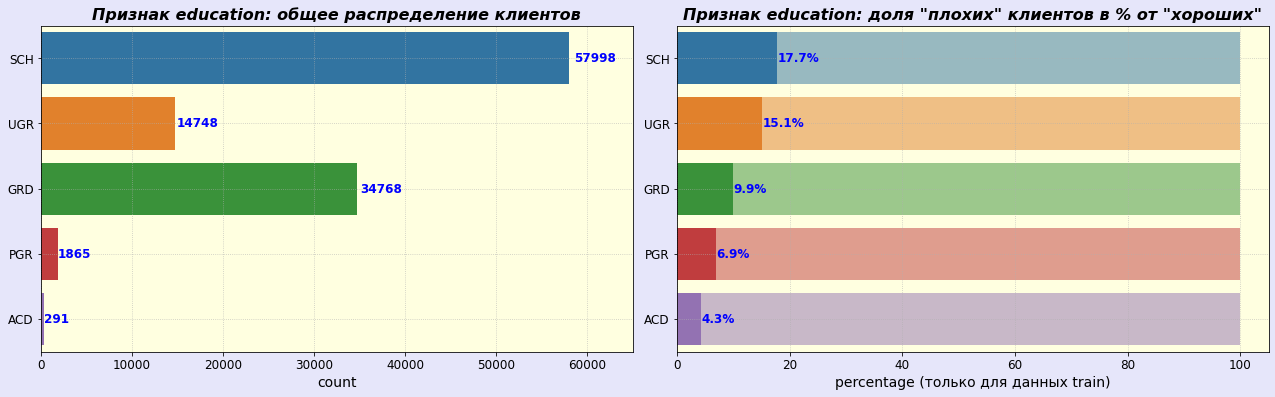

In [11]:
#------------------------------------------------------------------------------#
df = data.copy()
# Список с уровнями образования по возрастанию уровней:
cat_order = ['SCH', 'UGR', 'GRD', 'PGR', 'ACD']
# Строим графики:
df_tot, df_trg = get_simple_graph(df, 'education', cat_order)
ax = plt.gcf().get_axes(); ax[0].set_xlim([0, 65_000])
#---
display(df_tot); display(df_trg)

Посмотрим на матрицу корреляции данных в таблице `df_trg`.

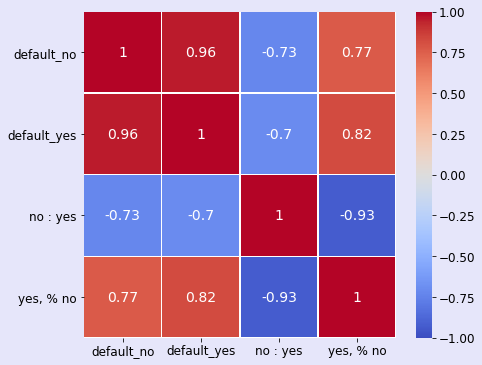

In [12]:
#------------------------------------------------------------------------------#
annot_kws = {'fontsize': 14}
sns.heatmap(df_trg.corr(), vmin=-1, vmax=1, annot = True, cmap= 'coolwarm',
            linewidths=.5, annot_kws=annot_kws)
plt.gcf().set_size_inches(7, 6)

* Тенденция выражена чётко: наиболее часто за получением кредита обращаются люди с низким образованием (чуть более половины клиентов в наборе данных). Чем выше образование клиента, тем реже он обращается в банк за кредитом. Можно предположить, что это связано с соответствующим распределением доходов: чем ниже уровень образования клиента, тем меньше его доход. Другими словами, должна наблюдаться связь между признаками `education` и `income`. Чуть позже мы выясним, так ли это.
* Похожая тенденция наблюдается с количеством "плохих" клиентов - их процентная доля снижается по мере роста уровня образования клиента. На графике вверху справа видно, что наибольшая доля "неплательщиков" имеет место у людей с самым низким (SCH) уровнем образования: 17.7%. Впрочем, график корреляций показывает сильную связь между долей неплательщиков `yes, %` (по отношению к плательщикам) и абсолютным числом неплательщиков `default_yes` - коэффициент корреляции равен 0.82.
* В абсолютном выражении тенденция чётко выражена - график корреляций показывает почти детерминированную связь между `default_yes` и `default_no`, коэффициент корреляции равен 0.96. Чем выше образование клиента, тем более он может считаться "хорошим" клиентом.
***

#### 1.3. Признак **income**.
Числовой признак. На первый взгляд, самый "очевидный" признак - чем выше доход у клиента, тем охотнее банк выдаст ему кредит... Ну, типа того.

Коэффициенты:
	- асимметрии: 7.503
	- эксцесса: 100.175

Границы дохода:
	- минимум:     1000
	- максимум: 1000000


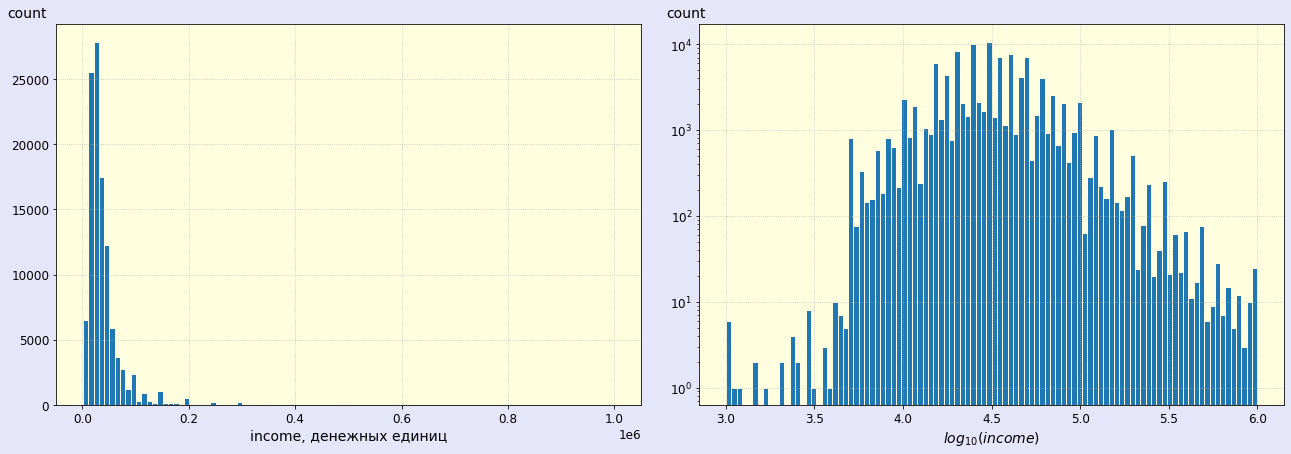

In [13]:
#------------------------------------------------------------------------------#
df = data.copy()
fig, ax = plt.subplots(1, 2, figsize=(22, 7)); fig.subplots_adjust(wspace=0.1)
# В абсолютных единицах:
df.income.hist(bins=100, ec='lightyellow', ax=ax[0])
# В логарифмическом масштабе:
df.income.apply(lambda x: np.log10(x)).hist(bins=100, ec='lightyellow',
                                            ax=ax[1], log=True)
ax[0].set_xlabel('income, денежных единиц')
ax[0].set_ylabel('count', rotation=0, position=(0, 1.01), ha="left")
ax[1].set_xlabel('$log_{10}(income)$')
ax[1].set_ylabel('count', rotation=0, position=(0, 1.01), ha="left")
#---
sk = df.income.skew()
kurt = df.income.kurtosis()
print(f'Коэффициенты:\n\t- асимметрии: {sk:5.3f}\n\t- эксцесса: {kurt:7.3f}')
min_val = df.income.min()
max_val = df.income.max()
print(f'\nГраницы дохода:\n\t- минимум: {min_val:>8d}\n\t- максимум: {max_val}')

Итак, мы видим, что распределение признака `income` имеет следующие особенности:
* существенно высокий положительный коэффициент асимметрии в 7.5 ед., что означает наличие тяжёлого правого хвоста.
* сильнейшую неоднородность распределения - эксцесс равен аж 100 ед., т.е. имеет место острейший пик в главном максимуме.
* банк выдаёт кредиты клиентам в весьма широком диапазоне их доходов - от 1 тыс. д.е. (денежных единиц) до 1 миллиона д.е.
* график в логарифмическом масштабе показывает, в частности, что левая часть распределения `income` резко уходит вниз для клиентов с малым доходом. Видим сравнительно малое количество таких клиентов, есть даже одиночные клиенты ($10^0$). Следует ли считать это аномалией или выбросом? Полагаю, что - нет. Такая ситуация представляется достаточно логичной: вряд ли следует ожидать массового наплыва за кредитом со стороны людей с очень низким доходом.

Обычная практика обработки подобных признаков состоит в применении монотонного преообразования. Это, например, логарифм, степенная функция или преобразование Бокса-Кокса. Мы это сделаем позже - в разделе подготовки данных к машинному обучению.
***

Посмотрим на распределение `income` с учётом целевой переменной `default`. Ясно, что можем использовать только данные из таблицы `train.csv`.

,min,mean,median,max
default,,,,
0,1000,41800,30000,1000000
1,3700,36288,28000,830000


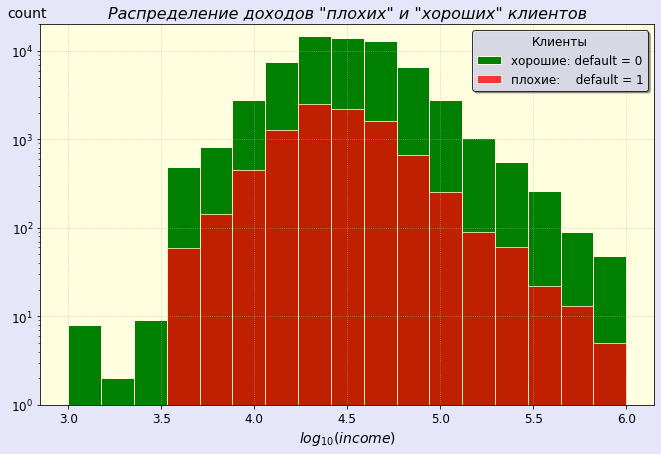

In [14]:
#------------------------------------------------------------------------------#
df = data[data.flag=='train'].copy()
# Прологарифмируем для удобства отображения:
df['income'] = df.income.apply(lambda x: np.log10(x))
df_0 = df[df.default==0]; df_1 = df[df.default==1]

fig, ax = plt.subplots(figsize=(11, 7))
#------------------------------------------------------------------------------#
k_bins = int(1. + 3.322 * np.log10(df.shape[0])) # Стерджес
min0 = df_0.income.min(); max0 = df_0.income.max()
step = (max0 - min0) / k_bins
bins = [ min0 + step * k for k in range(k_bins+1) ]
#---
df_0.income.hist(bins='sturges', ec='lightyellow', log=True, color='g',
                 label='хорошие: default = 0')
df_1.income.hist(bins=bins, ec='lightyellow', log=True, color='r',
                 label='плохие:    default = 1', alpha=0.75)
#---
ax.legend(title='Клиенты'); ax.set_xlabel('$log_{10}(income)$')
ax.set_ylabel('count', rotation=0, position=(0, 1.01), ha="left")
ax.set_title('Распределение доходов "плохих" и "хороших" клиентов',
             style='italic'); ax.set_ylim([1, 2*10**4])
#---
pd.options.display.float_format = '{:.0f}'.format
display(data[data.flag=='train'].groupby('default').income.agg(
                                        ['min', 'mean', 'median', 'max']))
pd.reset_option('float_format')

#### 1.4. Признаки **income** и **education**. Наличие связи.
Посмотрим, есть ли связь между доходом и уровнем ообразования. При этом "включим" опцию на подавление выбросов - для лучшей визуализации "ящиков".

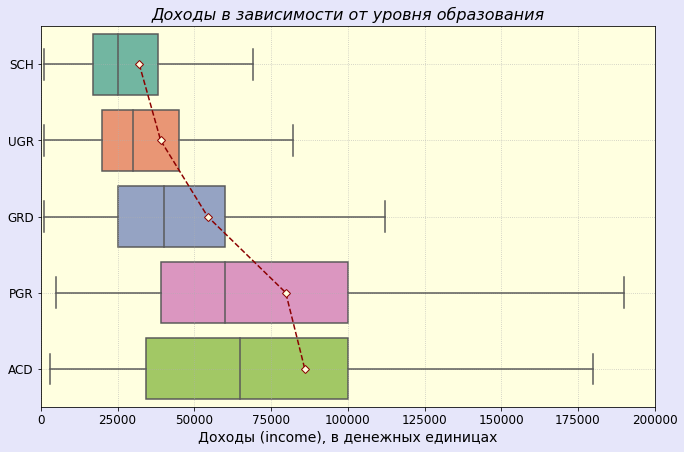

In [15]:
#------------------------------------------------------------------------------#
df = data[['income', 'education']].copy()
cat_order = ['SCH', 'UGR', 'GRD', 'PGR', 'ACD']
#---
fig, ax = plt.subplots(figsize=(11,7))
mean_props = dict(marker='D', markeredgecolor='DarkRed',
                  markerfacecolor='LightYellow')
sns.boxplot(data=df, x="income", y="education", palette="Set2",
            showmeans=True, meanprops=mean_props, showfliers=False,
            order=cat_order)
x_val = [df[df.education==k].income.mean() for k in cat_order]
y_val = [k for k,_ in enumerate(cat_order)]
ax.plot(x_val, y_val, color="DarkRed", ls="--")
#---
xmin = 0; xmax = 200_000; ax.set_xlim([xmin, xmax]);
ax.set_xlabel('Доходы (income), в денежных единицах'); ax.set_ylabel('')
ax.set_title('Доходы в зависимости от уровня образования', style='italic');
ax.grid("both")

Итак, действительно есть связь между уровнем образования и доходом: чем выше уровень образования, тем выше доход. Счастливые люди, однако. Я, имея кандидатскую степень, убил 10 лет своей жизни, работая за грошовую зарплату в одном из НИИ РАН. Молодой был да глупый, одной только наукой интересовался, аутист...  


Видим, что клиентов можно разбить на две группы. В первую группу входят заёмщики с уровнями образования SCH, UGR, GRD. Во вторую - PGR, ACD. Наблюдается заметный разрыв в уровнях дохода для этих двух групп: во второй группе доходы существенно выше как по медиане, так и по средней величине. Наименьший средний доход имеют клиенты с низким уровнем образования, наивысший - с высоким.  
Хорошо заметен сдвиг средней величины сильно вправо от медианы, что обусловлено наличием тяжёлого правого хвоста в распределениях.
***

#### 1.5. Признак **sex**.
Категориальный, бинарный признак.

In [16]:
#------------------------------------------------------------------------------#
df_sex = pd.DataFrame(data.sex.value_counts().astype('float'))
pd.options.display.float_format = '{:_.0f}'.format
display(df_sex)
pd.reset_option('float_format')
male = df_sex.loc['M', 'sex']; male_p = male * 100 / data.shape[0]
female = df_sex.loc['F', 'sex']; female_p = female * 100 / data.shape[0]
ratio = female / male
print(f'Соотношение "женщины / мужчины": {ratio:0.1f}')
print('\nДоля среди всех клиентов:')
print(f'\t- мужчины: {male_p:0.1f}%\n\t- женщины: {female_p:0.1f}%')

,sex
F,61_836
M,48_312


Соотношение "женщины / мужчины": 1.3

Доля среди всех клиентов:
	- мужчины: 43.9%
	- женщины: 56.1%


Клиентов-женщин заметно больше клиентов-мужчин. Отсюда уже можно сделать предварительный вывод, что среди клиентов-заёмщиков данного банка у женщин несколько ниже уровень образования и доход.

,type,count,percentage
0,M,48312,43.9
1,F,61836,56.1


,default_no,default_yes,no : yes,"yes, % no"
sex,,,,
M,27904,4333,6.4,15.5
F,36523,5039,7.2,13.8


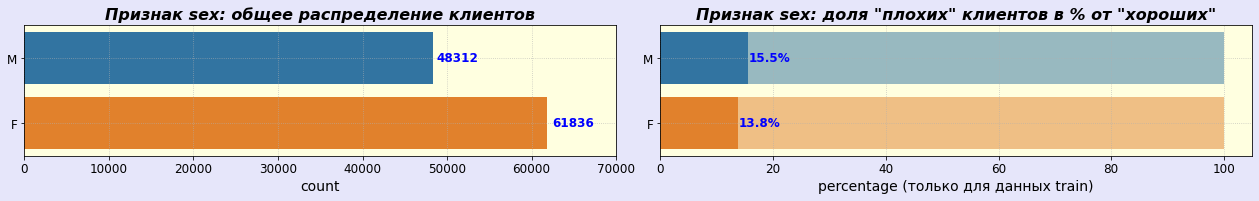

In [17]:
#------------------------------------------------------------------------------#
df = data.copy()
df_tot, df_trg = get_simple_graph(df, 'sex')
ax = plt.gcf().get_axes(); ax[0].set_xlim([0, 70_000])
display(df_tot); display(df_trg)

Несмотря на то, что женщин больше, чем мужчин, женщины являются более ответственными заёмщиками:
* при общем дисбалансе классов "хороший" / "плохой" в 6.9, женщины показывают больший коэффициент в 7.2 (`no : yes` во второй таблице), в том время как у мужчин это соотношение составляет 6.4
* у женщин доля неплательщиков (13.8%) меньше, чем у мужчин (15.5%)
***

Посмотрим, верно ли утверждение, что у женщин доход и уровень образования - ниже, чем у мужчин.

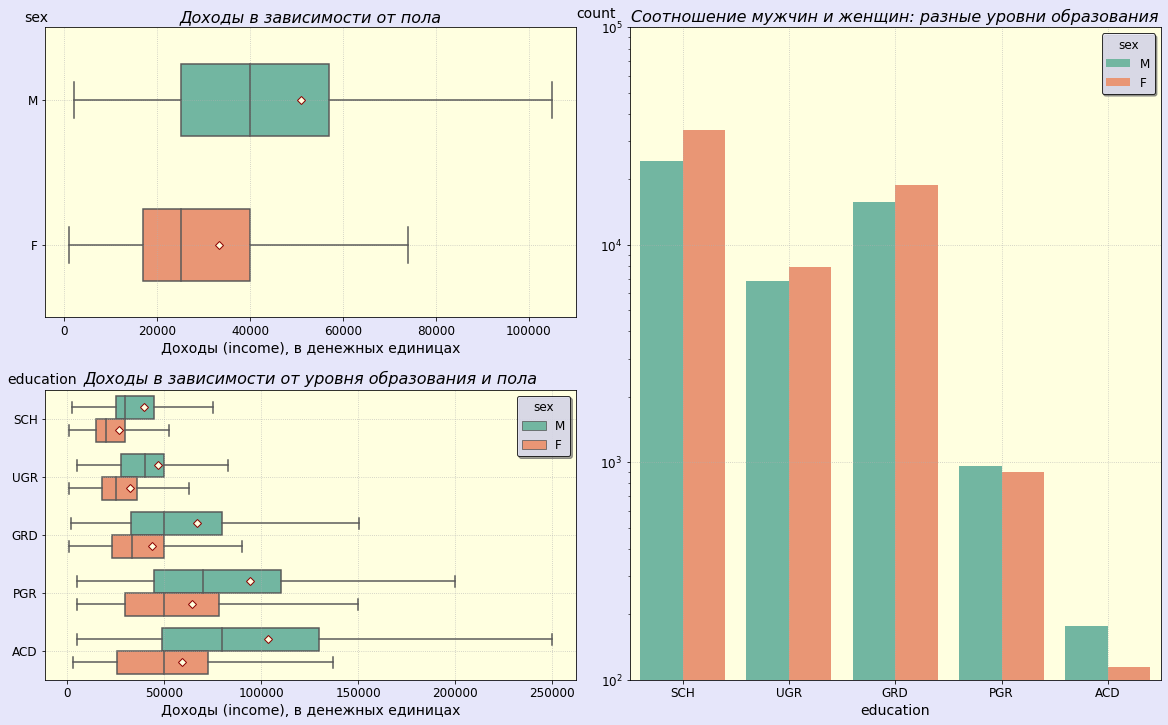

In [18]:
#------------------------------------------------------------------------------#
df = data.copy()
#---
cat_order = ['SCH', 'UGR', 'GRD', 'PGR', 'ACD']
fig, ax = plt.subplots(2, 2, figsize=(20, 12))
fig.subplots_adjust(wspace=0.1); fig.subplots_adjust(hspace=0.25)
ax3 = plt.subplot2grid((2,2), (0,1), rowspan=2, colspan=1)
mean_props = dict(marker='D', markeredgecolor='DarkRed',
                  markerfacecolor='LightYellow')
sns.boxplot(data=df, x="income", y="sex", palette="Set2",
            showmeans=True, meanprops=mean_props, showfliers=False,
            ax=ax[0,0], width=0.5)
sns.boxplot(data=df, x="income", y="education", hue="sex", palette="Set2",
            showmeans=True, meanprops=mean_props, showfliers=False,
            order=cat_order, ax=ax[1,0])
sns.countplot(data=df, x="education", hue="sex",
            palette="Set2", ax=ax3, order=cat_order)
#---
ax[0,0].set_xlabel('Доходы (income), в денежных единицах')
ax[0,0].set_title('Доходы в зависимости от пола', style='italic')
ax[0,0].set_ylabel('sex', rotation=0, position=(0, 1.01), ha="left")
#---
xmin = 0; xmax = 250_000; ax[0,1].set_xlim([xmin, xmax]);
ax[1,0].set_xlabel('Доходы (income), в денежных единицах');
ax[1,0].set_ylabel('education', rotation=0, position=(0, 1.01), ha="left")
ax[1,0].set_title('Доходы в зависимости от уровня образования и пола',
             style='italic')
#---
ax3.set_ylabel('count', rotation=0, position=(0, 1.01), ha="center");
ax3.set_title('Соотношение мужчин и женщин: разные уровни образования',
              style='italic')
#------------------------------------------------------------------------------#
[ax[k,0].grid("both") for k in [0, 1]]; ax3.grid("both"); ax3.set_yscale('log');
ax3.set_ylim(1e2, 1e5);

Да! Графики чётко и ясно показывают довольно существенную разницу в доходах у женщин и мужчин - на всех уровнях образования. Доходы женщин значительно меньше доходов мужчин. На общем графике (слева вверху) видно, что 3-я квартиль у женщин меньше медианы у мужчин, т.е. 3/4 женщин имеют доход, который меньше дохода половины мужчин.  
Также видно, что на низких уровнях образования женщин больше, чем мужчин. Особенно это касается самого низкого уровня `SCH`. Ситуация меняется только на двух самых высоких уровнях образования: PGR и ACD. На самом высоком уровне ACD мужчин заметно больше, чем женщин.

Кстати, чётко наблюдается одно из статистических эмпирических правил - с увеличением среднего выборочного растёт и выборочная дисперсия. Применительно к ящикам с усами  - чем больше медиана, тем больше межквартильный размах, т.е. длина ящика.
***

#### 1.6 Признак **age**.
Числовой признак.

Коэффициенты:
	- асимметрии: 0.480
	- эксцесса:  -0.726

Границы:
	- минимум:  21
	- максимум: 72

Мода: 31


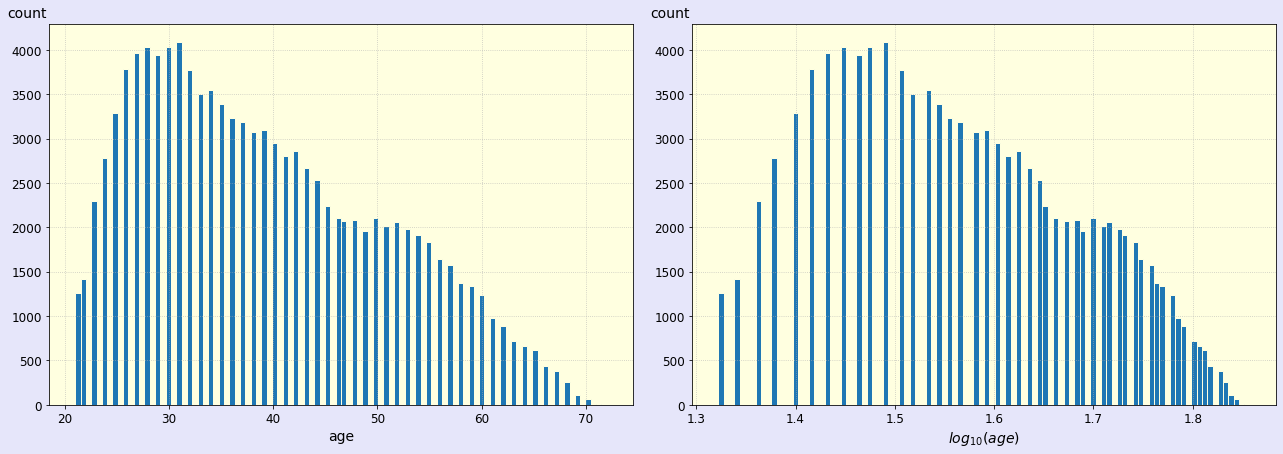

In [19]:
#------------------------------------------------------------------------------#
df = data.copy()
fig, ax = plt.subplots(1, 2, figsize=(22, 7)); fig.subplots_adjust(wspace=0.1)
# В абсолютных единицах:
df.age.hist(bins=100, ec='lightyellow', ax=ax[0])
# В логарифмическом масштабе:
df.age.apply(lambda x: np.log10(x)).hist(bins=100, ec='lightyellow',
                                            ax=ax[1])
ax[0].set_xlabel('age')
ax[0].set_ylabel('count', rotation=0, position=(0, 1.01), ha="left")
ax[1].set_xlabel('$log_{10}(age)$')
ax[1].set_ylabel('count', rotation=0, position=(0, 1.01), ha="left")
#---
sk = df.age.skew()
kurt = df.age.kurtosis()
print(f'Коэффициенты:\n\t- асимметрии: {sk:5.3f}\n\t- эксцесса: {kurt:7.3f}')
min_val = df.age.min()
max_val = df.age.max()
print(f'\nГраницы:\n\t- минимум: {min_val:>3d}\n\t- максимум: {max_val}')
print(f'\nМода: {df.age.mode()[0]}')

Итак, возраст заёмщиков меняется в широком диапазоне - от 21 до 72 лет. Наибольшее количество клиентов имеют возраст 31 год. Распределение возраста клиентов похоже на треугольное. Распределение имеет тяжёлый правый хвост, а отрицательный коэффициент эксцесса свидетельствует, что распределение является более плоским, нежели нормальное распределение.
***
Посмотрим, как распределены по возрасту "хорошие" и "плохие" клиенты.

Критерий Колмогорова-Смирнова:
	- p-value: 2.9e-11


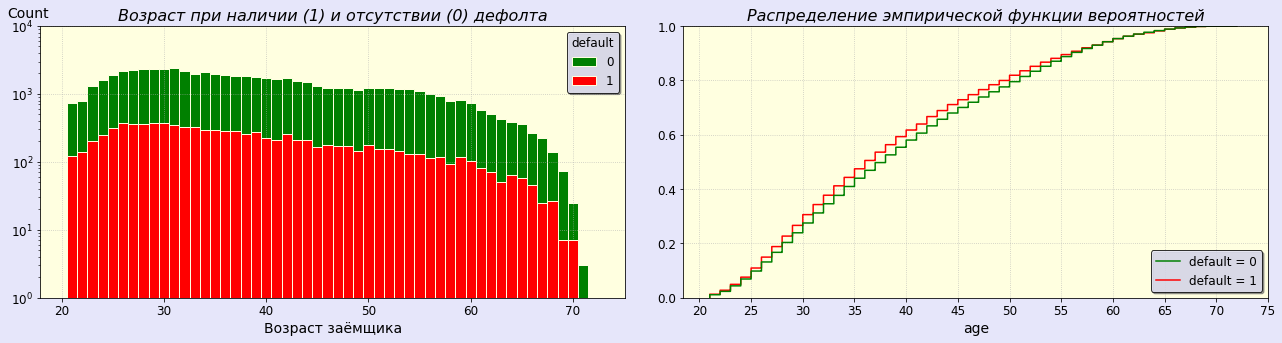

In [20]:
#------------------------------------------------------------------------------#
df = data[data.flag=='train'].copy()
#---
fig, ax = plt.subplots(1, 2, figsize=(22, 5)); fig.subplots_adjust(wspace=0.1)
sns.histplot(data=df, x="age", hue="default", palette=["g", "r"], alpha=1,
             discrete=True, ax=ax[0], edgecolor='lightyellow')
sns.ecdfplot(data=df, x="age", hue="default", palette=["g", "r"], ax=ax[1])
#---
[axs.grid("both") for axs in ax]
ax[0].set_xlabel('Возраст заёмщика')
ax[0].set_title('Возраст при наличии (1) и отсутствии (0) дефолта',
                style='italic')
ax[0].set_ylabel('Сount', rotation=0, position=(0, 1.02), ha="left")
ax[0].set_yscale("log"); ax[0].set_ylim(1e0, 1e+4);
#---
green_line = mlines.Line2D([], [], color='green', label='default = 0')
red_line = mlines.Line2D([], [], color='red', label='default = 1')
ax[1].legend(handles=[green_line, red_line], loc="lower right")
ax[1].set_title('Распределение эмпирической функции вероятностей',
                style='italic')
ax[1].set_ylabel(''); ax[1].set_xticks(range(20,80,5))#; ax[1].set_xlim(20,70)
#---
print('Критерий Колмогорова-Смирнова:')
ds_0 = df[df.default==0].age.values
ds_1 = df[df.default==1].age.values
_, p_value = ks_2samp(ds_0, ds_1)
print(f'\t- p-value: {p_value:0.2g}')
#------------------------------------------------------------------------------#
num = df[df.default==1].age.nunique()
[ax[0].get_children()[k].set_zorder(2) for k in range(num)];

Накопленная разница между двумя распределениями не позволяет принять нулевую гипотезу о том, что эмпирические функции распределения `F(age|default=0)` и `G(age|default=1)` различаются незначимо.
***

#### 1.7 Признаки **car** и **car_type**.
Оба признака категориальные бинарного типа.

=== Признак car ===


,type,count,percentage
0,Y,35858,32.6
1,N,74290,67.4


,default_no,default_yes,no : yes,"yes, % no"
car,,,,
Y,21420,2547,8.4,11.9
N,43007,6825,6.3,15.9


=== Признак car_type ===


,type,count,percentage
0,Y,21008,19.1
1,N,89140,80.9


,default_no,default_yes,no : yes,"yes, % no"
car_type,,,,
Y,12783,1225,10.4,9.6
N,51644,8147,6.3,15.8


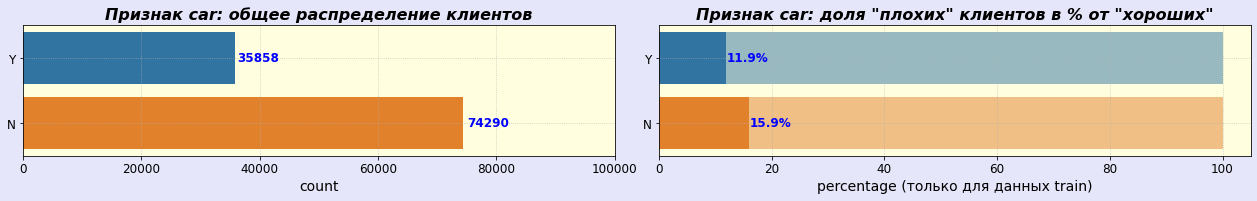

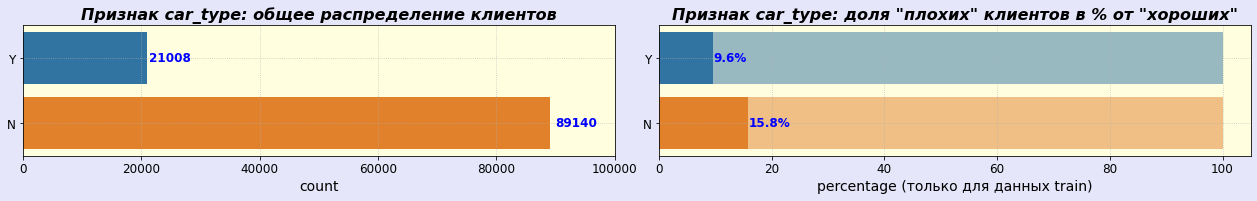

In [21]:
#------------------------------------------------------------------------------#
df = data.copy()
# Признак car:
print('=== Признак car ===')
df_tot, df_trg = get_simple_graph(df, 'car')
ax = plt.gcf().get_axes(); ax[0].set_xlim([0, 100_000])
display(df_tot); display(df_trg)
print('=== Признак car_type ===')
# Признак car_type:
df_tot, df_trg = get_simple_graph(df, 'car_type')
ax = plt.gcf().get_axes(); ax[0].set_xlim([0, 100_000])
display(df_tot); display(df_trg)

Итак, владельцы автомобилей и "безлошадные" клиенты распределились почти как треть (32.6%) и две трети (67.7%) от общего количества клиентов соответственно. "Автомобилисты" более ответственно подходят к выплате займа, нежели "пешеходы": доля "плохих" клиентов среди владельцев автомобиля (11.9%) заметно меньше "плохих" клментов без автомобиля (15.9%).
***
Что касается признака `car_type`, который сигнализирует об "иномарке", то было бы логичным смотреть на распределение этого признака среди владельцев автомобилей. Однако для проверки корректности данных следует также проверить этот признак и для тех клиентов, у которых нет автомобиля.

In [22]:
#------------------------------------------------------------------------------#
df.groupby(['car','car_type'])[['age']].count().rename(columns={'age':'count'})

count
car car_type       
N   N         74290
Y   N         14850
    Y         21008

Вывод: для признаков `car` и `car_type` имеющиеся данные являются согласованными - мы видим, что категория "Y" признака `car_type`, сигнализирующая о наличии автомобиля-"иномарки", встречается только среди тех клиентов, которые являются автовладельцами. У клиентов без автомобиля эта категория отсутствует, как и должно быть.
***
С точки зрения "житейской логики", наличие автомобиля, а тем более - "иномарки", свидетельствует о сравнительно высоком уровне доходов. Вряд ли человек с низким доходом будет покупать автомобиль. Впрочем, в последнее десятилетие народ сошёл с ума, поддаваясь навязчивой рекламе всяческих кредитов на бытовые нужды. Берут один кредит, затем другой, а чтобы обслуживать эти кредиты, берут ещё один... И сидят на "дошираке" с пустым чаем... Однако посмотрим, как в наших данных соотносятся доходы (признак `income`) и наличие автомобиля (признаки `car` и `car_type`). Заодно попробуем учесть целевой признак `default`.

income:,no_car,car_domestic,car_foreign
quantile,,,
25%,18_000,22_000,35_000
50%,25_000,30_000,50_000
75%,40_000,45_000,80_000


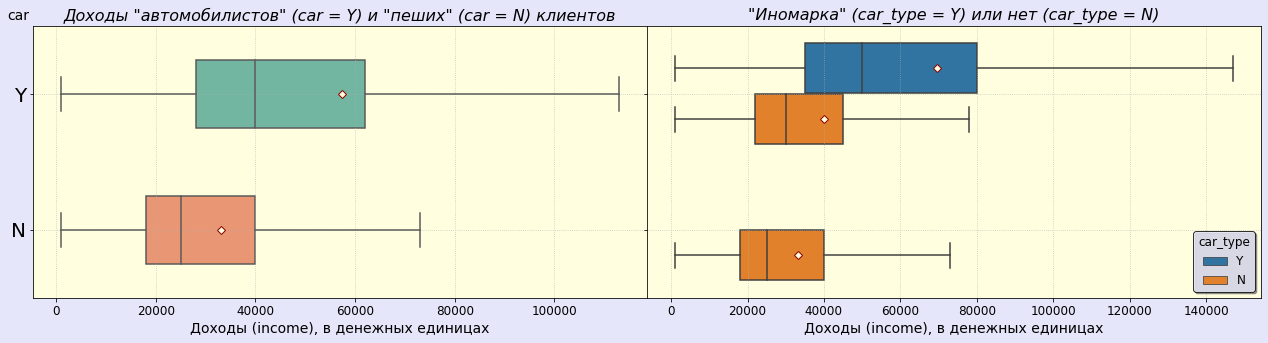

In [23]:
#------------------------------------------------------------------------------#
df = data.copy()
plt.rcParams.update({"ytick.labelsize": 20})
#---
fig, ax = plt.subplots(1, 2, figsize=(22, 5), sharey=True)
fig.subplots_adjust(wspace=0.)
#---
mean_props = dict(marker='D', markeredgecolor='DarkRed',
                  markerfacecolor='LightYellow')
sns.boxplot(data=df, x="income", y="car", palette="Set2", showmeans=True,
            meanprops=mean_props, showfliers=False, ax=ax[0], width=0.5)
sns.boxplot(data=df, x="income", y="car", hue="car_type", palette="tab10",
            showmeans=True, meanprops=mean_props, showfliers=False, ax=ax[1],
            width=0.75)
#---
[axs.grid("both") for axs in ax]
ax[0].set_xlabel('Доходы (income), в денежных единицах')
ax[0].set_title('Доходы "автомобилистов" (car = Y) и "пеших" (car = N) клиентов',
                style='italic')
ax[0].set_ylabel('car', rotation=0, position=(0, 1.01), ha="left")
#---
ax[1].set_xlabel('Доходы (income), в денежных единицах')
ax[1].set_title('"Иномарка" (car_type = Y) или нет (car_type = N)',
                style='italic')
ax[1].set_ylabel('');
#------------------------------------------------------------------------------#
set_rc_params()
#------------------------------------------------------------------------------#
df_YY = df[(df.car=='Y')&(df.car_type=='Y')][['income']] # Иномарки
df_YN = df[(df.car=='Y')&(df.car_type=='N')][['income']] # НЕ иномарки
df_NN = df[df.car=='N'][['income']]                      # Безлошадные
df_stats = df_NN.describe().loc[['25%', '50%', '75%']].join(
           df_YN.describe().loc[['25%', '50%', '75%']], rsuffix='_YN').join(
           df_YY.describe().loc[['25%', '50%', '75%']], rsuffix='_YY')
df_stats.columns = ['no_car', 'car_domestic', 'car_foreign']
df_stats = df_stats.rename_axis("income:", axis=1)
df_stats = df_stats.rename_axis("quantile", axis=0)
pd.options.display.float_format = '{:_.0f}'.format
display(df_stats)
pd.reset_option('float_format')

На графике слева хорошо видно, что доходы клиентов-автовладельцев заметно превышают доходы клиентов без автомобиля. Визуально, третья квартиль "безлошадных" равна медиане доходов у автомобилистов, т.е. наблюдается та же тенденция в доходах, которая была установлена ранее при сравнении доходов мужчин и женщин: доходы половины клиентов-автовладельцев превышают доходы 3/4 клиентов без автомобиля. Кроме того, если не учитывать выбросы, доходы автовладельцев изменяются в более широком диапазоне.  
График справа учитывает разницу в доходах владельцев "иномарок" и клиентов, имеющих в собственности отечественный автомобиль. Продублированы также доходы клиентов без автомобиля. Поляризация доходов на графике справа - ещё более существенная.

Таким образом, "житейская логика" оказалась здесь вполне правильной: у владельцев иномарок доход заметно выше, чем у владельцев отечественных автомобилей и у клиентов без автомобилей.
***
Попробуем учесть default, сделаем просто.

INCOME:                min  median   mean
car car_type default                     
Y   N        0       1_000  30_000 40_586
             1       4_000  30_000 38_304
    Y        0       2_000  50_000 70_551
             1       5_000  45_000 63_820
N   N        0       1_000  26_000 33_498
             1       3_700  25_000 30_956

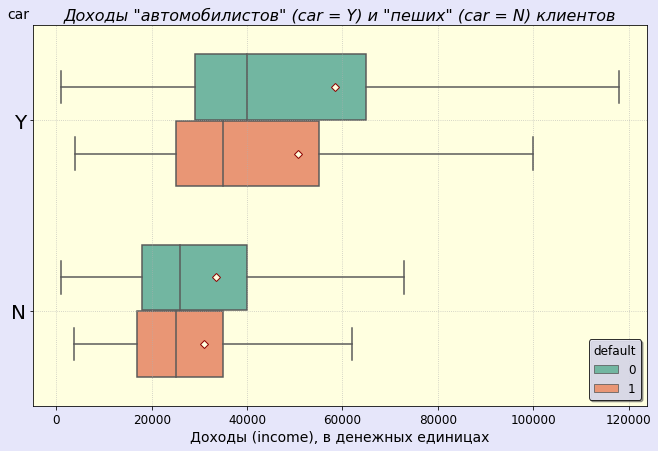

In [24]:
df = data[data.flag=='train'].copy()
#------------------------------------------------------------------------------#
plt.rcParams.update({"ytick.labelsize": 20}) # Размер шрифта меток оси Y
#------------------------------------------------------------------------------#
fig, ax = plt.subplots(figsize=(11, 7))
#---
mean_props = dict(marker='D', markeredgecolor='DarkRed',
                  markerfacecolor='LightYellow')
sns.boxplot(data=df, x="income", y="car", hue="default", palette="Set2",
            showmeans=True, meanprops=mean_props, showfliers=False, width=0.7)
#---
ax.grid("both")
ax.set_xlabel('Доходы (income), в денежных единицах')
ax.set_title('Доходы "автомобилистов" (car = Y) и "пеших" (car = N) клиентов',
                style='italic')
ax.set_ylabel('car', rotation=0, position=(0, 1.01), ha="left");
#------------------------------------------------------------------------------#
set_rc_params() # Вернулись к исходным пользовательским настройкам графики
#------------------------------------------------------------------------------#
dff = df.groupby(['car', 'car_type', 'default']).income.agg(
                                                    ['min', 'median', 'mean'])
for col in dff.columns: dff[col] = dff[col].apply(float)
pd.options.display.float_format = '{:_.0f}'.format
display(dff.loc[['Y', 'N']].rename_axis("INCOME:", axis=1))
pd.reset_option('float_format')

"Житейская логика" нормально работает и в этом случае, если рассмотретить два крайних "ящика": верхний, показывающий доход "хороших" клиентов-автомобилистов, и нижний, в котором сосредоточены "плохие" клиенты без автомобиля. Видно, что "хорошие" автомобилисты имеют гораздо больший доход, нежели "плохие" "безлошадные" клиенты.
***

#### 1.8 Признаки **decline_app_cnt** и **bki_request_cnt**.
* decline_app_cnt - количество отказанных прошлых заявок
* bki_request_cnt - количество запросов в БКИ

"Житейская логика" подсказывает, что чем больше отказов, тем более вероятен дефолт клиента по кредиту - кредиторы ведь не просто так отказались в прошлом выдавать кредиты данному клиенту. Что же касается признака `bki_request_cnt`, то та же логика говорит о связи между двумя событиями: клиент обратился за кредитом, кредитор для проверки клиента сделал запрос в БКИ. Кроме того, `bki_request_cnt` содержит также запросы самого клиента в Бюро кредитных историй.  

Можно ли "вытащить" что-то полезное из совместного рассмотрения признаков `decline_app_cnt` и `bki_request_cnt`? Увидим.

Посмотрим на распределения этих признаков "в лоб" и в логарифмическом масштабе.

,skew,kurtosis
decline_app_cnt,6.5,101.2
bki_request_cnt,3.1,23.2


feature value:,0,1,2,3,4,5,6,7,8,9
bki_request_cnt,28_908,27_295,20_481,13_670,8_406,4_960,2_500,1_292,735,459
decline_app_cnt,91_471,12_500,3_622,1_365,606,255,156,58,37,29


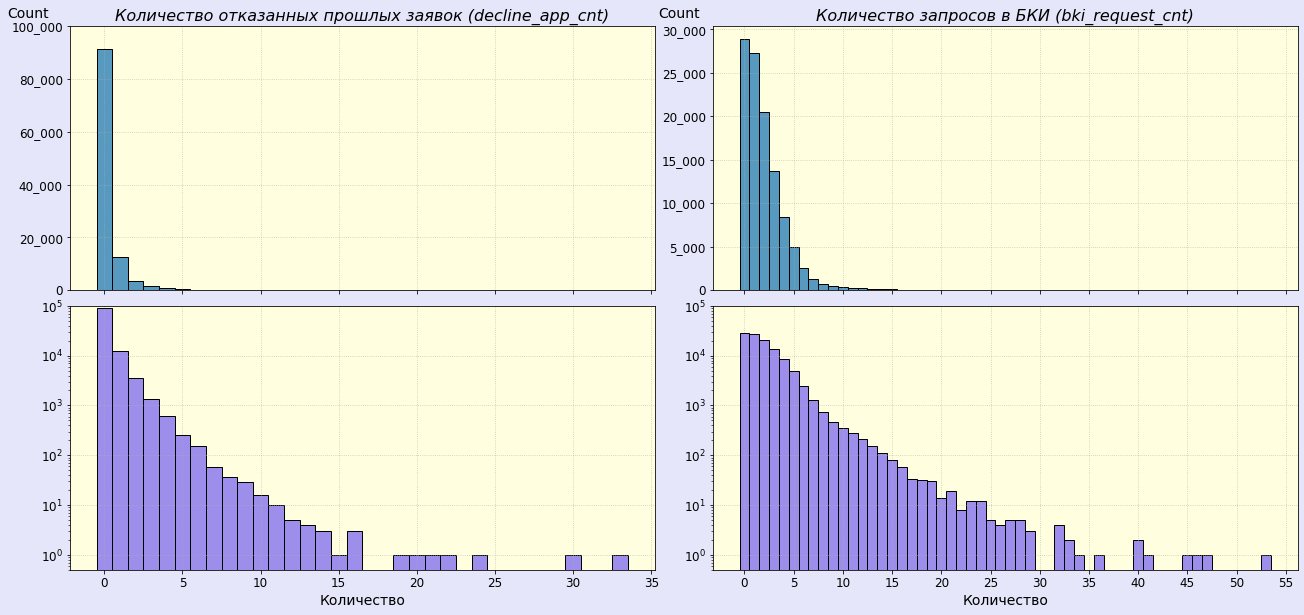

In [25]:
#------------------------------------------------------------------------------#
df = data.copy()
#---
fig, ax = plt.subplots(2, 2, figsize=(22, 10), sharex="col");
fig.subplots_adjust(wspace=0.1); fig.subplots_adjust(hspace=0.06)
# Распределение "в лоб":
sns.histplot(data=df, x="decline_app_cnt", ax=ax[0,0], discrete=True)
sns.histplot(data=df, x="bki_request_cnt", ax=ax[0,1], discrete=True)
#---
ax[0,0].set_title('Количество отказанных прошлых заявок (decline_app_cnt)',
                style='italic')
ax[0,1].set_title('Количество запросов в БКИ (bki_request_cnt)',
                style='italic');
# Распределение в логарифмическом масштабе:
sns.histplot(data=df, x="decline_app_cnt", ax=ax[1,0], discrete=True,
             color="MediumSlateBlue")
sns.histplot(data=df, x="bki_request_cnt", ax=ax[1,1], discrete=True,
             color="MediumSlateBlue");
#---
for k in [0,1]:
    ax[0,k].set_ylabel('Count', rotation=0, position=(0., 1.02), ha="left")
    ax[1,k].set_xlabel('Количество')
    ax[k,1].set_xticks(range(0, 60, 5))
    ax[1,k].set_yscale("log")
    ax[1,k].set_ylim(5e-1, 1e5)
    ax[1,k].set_ylabel('')
    ax[0,k].yaxis.set_major_formatter('{x:_.0f}')
ax[0,0].set_ylim(0, 100_000)
#------------------------------------------------------------------------------#
# Асимметрия и эксцесс:
cols = ['decline_app_cnt', 'bki_request_cnt']
df_skew_kurt = pd.DataFrame([df[cols].skew(), df[cols].kurtosis()], 
                            index=['skew', 'kurtosis'])
for col in cols: df_skew_kurt[col] = df_skew_kurt[col].apply('{0:.1f}'.format)
display(df_skew_kurt.T)
# Распределение событий на первых 10 реализациях признаков, например,
# для decline_app_cnt: 0 отказов, 1 отказ, ... , 9 отказов:
decline = pd.DataFrame(df.decline_app_cnt.value_counts(sort=False)[:10])
request = pd.DataFrame(df.bki_request_cnt.value_counts(sort=False)[:10])
proba_dist = decline.join(request)
proba_dist = request.join(decline)
for col in proba_dist.columns:
    proba_dist[col] = proba_dist[col].apply('{:_}'.format)
proba_dist.T.rename_axis('feature value:', axis=1)

Видим, что имеет место сильно неоднородное распределение - основная доля клиентов сосредоточена вблизи нулевой отметки (большой эксцесс). Есть длинный правый хвост, тянущийся в область редких значений (высокая асимметрия). Наибольшую неоднородность демонстрирует признак `decline_app_cnt`: из второй таблицы видно, что подавляющее большинство клиентов сосредоточено на отметке 0 (91_471 клиент или 83% от всех клиентов, представленных в исходной базе данных). В то же время признак `bki_request_cnt` показывает более однородное распределение. Формально, оба признака являются числовыми. Однако сильная неоднородность распределения (особенно признака `decline_app_cnt`) приводит к тому, что признаки являются "скорее категориальными", нежели числовыми.  
Общий вывод с точки зрения "житейской логики". *Судя по `decline_app_cnt`, абсолютное большинство клиентов банка либо пришли за кредитом в первый раз, либо не имели отказов по прошлым кредитам.*  

Оценим ограничения на соотношение признаков `decline_app_cnt` и `decline_app_cnt`. Сначала введём для краткости следующие обозначения: признак `decline_app_cnt` обозначим через $Y$, а `bki_request_cnt` - через $X$, и будем рассматривать $X$ и $Y$ как дискретные случайные величины:
\begin{equation}
X = \{0, 1, ..., m\},\\Y = \{0, 1, ..., n\},
\end{equation}
где $m, n$ - максимальные значения соответствующих случайных величин.  

Сделаем предположение: **_каждое обращение клиента за кредитом сопровождается обращением в БКИ_**.

Конечно, клиент тоже осуществляет запросы в БКИ, но сделанное предположение приводит к следующему ограничению на $X$ и $Y$: $Y \le X$.  
В самом деле, пусть $Y = 1$, т.е. у клиента был один отказ по кредитной заявке. Это значит, что хотя бы раз было обращение в БКИ со стороны банка, в котором клиент подавал заявку. Следовательно, $X \ge 1$. Пусть у другого клиента было два отказа $Y = 2$. Значит, было хотя бы два обращения в БКИ, и $X$ не может быть меньше 2: $X \ge 2$. И так далее. Установленное ограничение приводит к тому, что множество точек на плоскости $X, Y$ ограничено координатными осями и линией $Y = X$.

Посмотрим, удовлетворяют ли имеющиеся данные указанному ограничению.

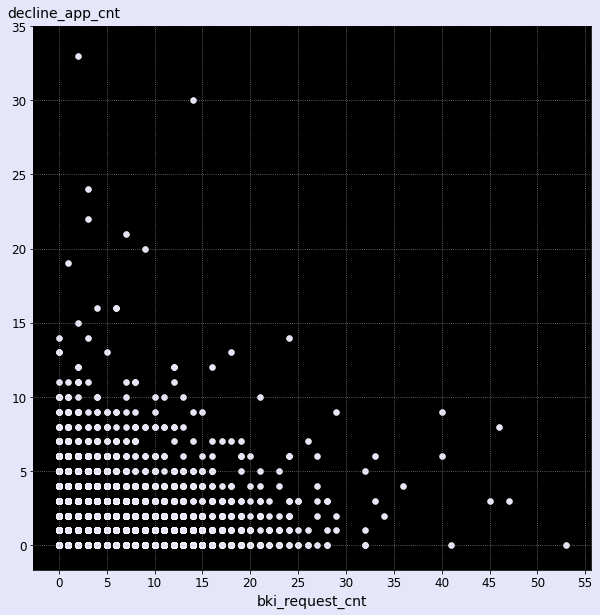

In [26]:
#------------------------------------------------------------------------------#
df = data.copy()
#---
fig, ax = plt.subplots(figsize=(10, 10)); ax.set_facecolor('black')
sns.scatterplot(data=df, x="bki_request_cnt", y="decline_app_cnt",
                color="lavender", ax=ax);
ax.set_ylabel("decline_app_cnt", rotation=0, position=(0., 1.01), ha="left")
ax.set_xticks(range(0,60,5)); ax.set_yticks(range(0,40,5));

Итак, видим, что данные не удовлетворяют установленному ограничению. Так, например, при отсутствии запросов в БКИ (bki_request_cnt = 0) наблюдается значительное количество клиентов, имеющих отказы по кредиту. Что будем делать? При подготовке данных к обучению модели мы скорректируем значения признаков `decline_app_cnt` и `bki_request_cnt`. Самый простой способ корректировки, к примеру, может выглядеть так:
```python
if decline_app_cnt > bki_request_cnt:
    decline_app_cnt = bki_request_cnt
```
Это позволит, в частности, уменьшить количество значений признака `decline_app_cnt`.
***
Рассмотрим распределение этих двух признаков с учётом целевой переменной `default`.

feature value:,0,1,2,3,4,5,6,7,8,9
decline_app_cnt,61_214,8_397,2_468,903,414,165,113,48,19,24
bki_request_cnt,19_381,18_276,13_749,9_187,5_627,3_268,1_704,852,508,299


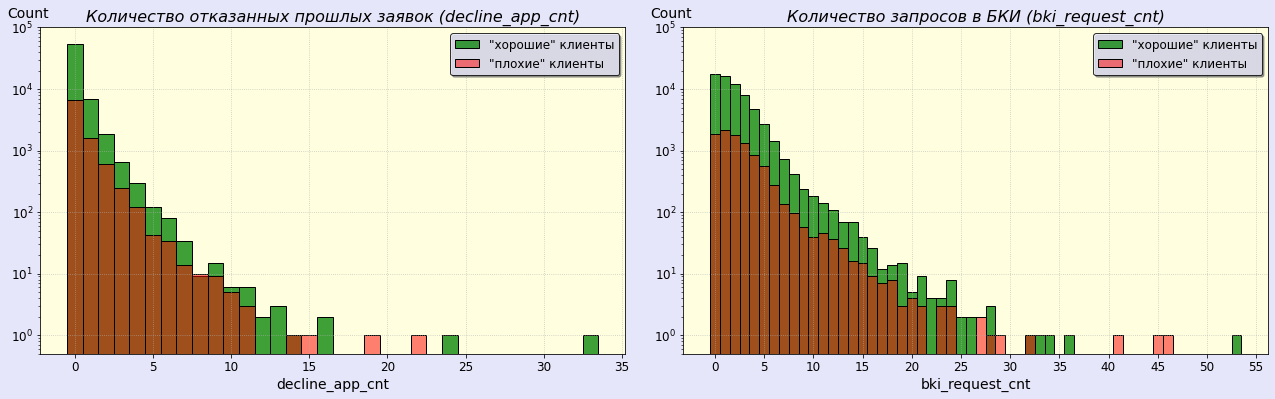

In [27]:
df = data.copy()
#------------------------------------------------------------------------------#
df = df[df.flag=='train']
# Распределение в логарифмическом масштабе:
fig, ax = plt.subplots(1, 2, figsize=(22, 6)); fig.subplots_adjust(wspace=0.1)
[axs.set_yscale("log") for axs in ax]
# Признак decline_app_cnt:
sns.histplot(data=df[df.default==0], x="decline_app_cnt", ax=ax[0],
             color="green", discrete=True, label='"хорошие" клиенты')
sns.histplot(data=df[df.default==1], x="decline_app_cnt", ax=ax[0],
             color="red", discrete=True, alpha=0.5, label='"плохие" клиенты')
# Признак bki_request_cnt:
sns.histplot(data=df[df.default==0], x="bki_request_cnt", ax=ax[1],
             color="green", discrete=True, label='"хорошие" клиенты')
sns.histplot(data=df[df.default==1], x="bki_request_cnt", ax=ax[1],
             color="red", discrete=True, alpha=0.5, label='"плохие" клиенты')
#---
ax[0].legend(); ax[0].set_ylim([5e-1, 1e5])
ax[0].set_ylabel('Count', rotation=0, position=(0., 1.02), ha="left")
ax[0].set_title('Количество отказанных прошлых заявок (decline_app_cnt)',
                style='italic')
#---
ax[1].legend(); ax[1].set_ylim([5e-1, 1e5])
ax[1].set_xticks(range(0, 60, 5))
ax[1].set_ylabel('Count', rotation=0, position=(0., 1.02), ha="left")
ax[1].set_title('Количество запросов в БКИ (bki_request_cnt)',
                style='italic');
#------------------------------------------------------------------------------#
# Распределение событий на первых 10 реализациях признаков, например,
# для decline_app_cnt: 0 отказов, 1 отказ, ... , 9 отказов:
decline = pd.DataFrame(df.decline_app_cnt.value_counts(sort=False)[:10])
request = pd.DataFrame(df.bki_request_cnt.value_counts(sort=False)[:10])
proba_dist = decline.join(request)
for col in proba_dist.columns:
    proba_dist[col] = proba_dist[col].apply('{:_}'.format)
proba_dist.T.rename_axis('feature value:', axis=1)

При взгляде на формы гистограмм в логарифмическом масштабе создаётся впечтление, что признак `decline_app_cnt` имеет лапласово распределение с большим коэффициентом масштаба, а признак `bki_request_cnt` - распределение Гаусса с малой дисперсией, причём у обоих распределений математическое ожидание равно нулю (половина распределения).
***
На первый взгляд, гистограммы "хороших" и "плохих" клиентов похожи. Оценим, насколько они похожи. Для этого используем критерий Колмогорова-Смирнова, который определяет "расстояние" между функциями распределения вероятностей.  
Нулевая гипотеза: эмпирические функции распределения вероятностей "хороших" и "плохих" клиентов не имеют значимых различий.

In [28]:
#------------------------------------------------------------------------------#
print('Величина p-value для признаков:')
# decline_app_cnt:
data1 = df[df.default==0].decline_app_cnt.values
data2 = df[df.default==1].decline_app_cnt.values
_, p_value = ks_2samp(data1, data2)
print(f'\t- decline_app_cnt: {p_value:0.3g}')
# bki_request_cnt:
data1 = df[df.default==0].bki_request_cnt.values
data2 = df[df.default==1].bki_request_cnt.values
_, p_value = ks_2samp(data1, data2)
print(f'\t- bki_request_cnt: {p_value:0.3g}')

Величина p-value для признаков:
	- decline_app_cnt: 3.4e-122
	- bki_request_cnt: 1.49e-63


Нулевая гипотеза отвергается. Для признаков `decline_app_cnt` и `bki_request_cnt` "хорошие" и "плохие" клиенты имеют значимо различающиеся функции распределения вероятностей.
***

#### 1.9 Признак **good_work**.
Наличие "хорошей" работы. Категориальный признак бинарного типа, уже перекодирован в числа 0 и 1.

,type,count,percentage
0,0,91917,83.4
1,1,18231,16.6


,default_no,default_yes,no : yes,"yes, % no"
good_work,,,,
0,53408,8222,6.5,15.4
1,11019,1150,9.6,10.4


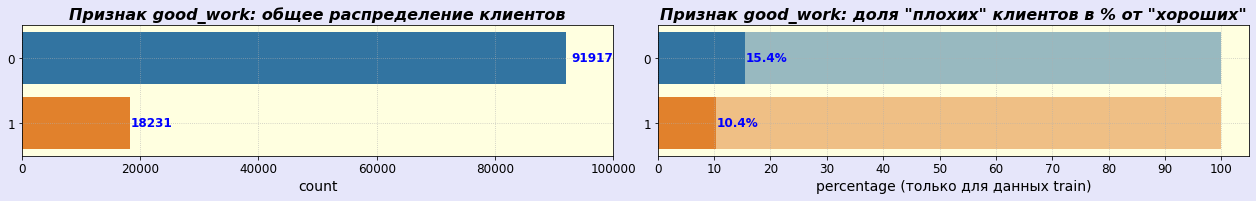

In [29]:
#------------------------------------------------------------------------------#
df = data.copy()
df.good_work = df.good_work.replace({1: '1', 0: '0'})
col = 'good_work'
df_tot, df_trg = get_simple_graph(df, 'good_work')
ax = plt.gcf().get_axes(); ax[0].set_xlim([0, 100_000])
ax[1].set_xticks(range(0, 110, 10))
display(df_tot); display(df_trg)

Подавляющее большинство (83%) клиентов банка не имеют "хорошую" работу. Видно, что люди с "хорошей" работой являются более ответственными клиентами - доля "плохих" клиентов среди них составляет 10%, а среди людей, не имеющих "хорошую" работу - в полтора раза больше (15%).
***
Посмотрим, как распределяются доходы у тех, кто имеет "хорошую" работу, и у тех, кто не попал в эту категорию. Учтём при этом целевой признак `default`.

INCOME:              min  median    mean
good_work default                       
0         0        1_000  30_000  41_280
          1        3_700  27_900  36_435
1         0        1_000  35_000  44_316
          1        4_500  29_250  35_240

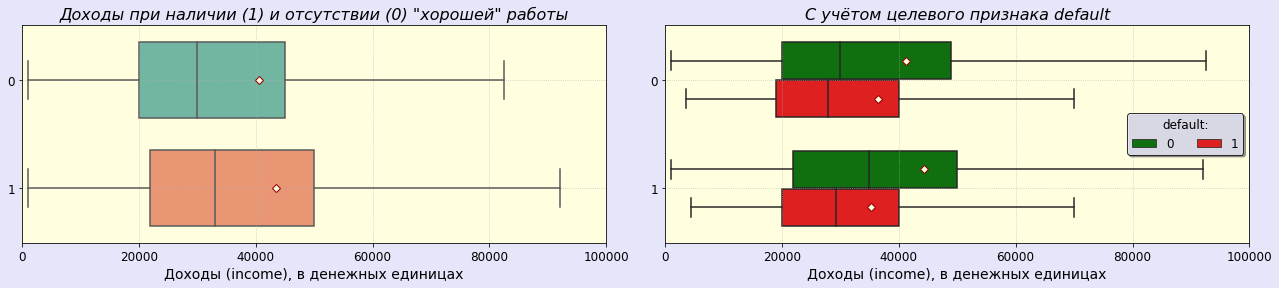

In [30]:
#------------------------------------------------------------------------------#
df = data[data.flag=='train'].copy()
df.good_work = df.good_work.replace({0: '0', 1: '1'})
#---
fig, ax = plt.subplots(1, 2, figsize=(22, 4)); fig.subplots_adjust(wspace=0.1)
mean_props = dict(marker='D', markeredgecolor='DarkRed',
                  markerfacecolor='LightYellow')
sns.boxplot(data=df, x="income", y="good_work", palette="Set2",
            showmeans=True, meanprops=mean_props, showfliers=False, width=0.7,
            ax=ax[0])
sns.boxplot(data=df, x="income", y="good_work", hue="default", 
            showmeans=True, meanprops=mean_props, showfliers=False, width=0.7,
            ax=ax[1], palette=["g", "r"])
#---
[axs.set_xlabel('Доходы (income), в денежных единицах') for axs in ax]
[axs.grid("both") for axs in ax]
[axs.set_xlim([0, 100_000]) for axs in ax]
ax[0].set_title('Доходы при наличии (1) и отсутствии (0) "хорошей" работы',
             style='italic')
ax[0].set_ylabel('')
#---
ax[1].legend(loc="center right", ncol=2, title="default:"); ax[1].set_ylabel('')
ax[1].set_title('С учётом целевого признака default', style='italic');
#------------------------------------------------------------------------------#
dff = df.groupby(['good_work', 'default']).income.agg(
                                                    ['min', 'median', 'mean'])
for col in dff.columns: dff[col] = dff[col].apply('{:_.0f}'.format)
display(dff.rename_axis("INCOME:", axis=1))

В целом, можно отметить, что доходы при наличии "хорошей" работы несколько выше, чем в отсутствие оной. Дефолтные клиенты как в том, таки и в другом случае имеют меньший доход (медиана, среднее), чем надёжные клиенты.
***

#### 1.10 Признаки **home_address** и **work_address**.
Категориальные переменные. Видимо, ординального типа.  
Пока не знаю, что именно закодировано в этих признаках. Посмотрим по распределениям.

=== home_address ===


,type,count,percentage
0,1,48688,44.2
1,2,59591,54.1
2,3,1869,1.7


,default_no,default_yes,no : yes,"yes, % no"
home_address,,,,
1,29558,3027,9.8,10.2
2,33757,6199,5.4,18.4
3,1112,146,7.6,13.1


=== work_address ===


,type,count,percentage
0,1,12274,11.1
1,2,30761,27.9
2,3,67113,60.9


,default_no,default_yes,no : yes,"yes, % no"
work_address,,,,
1,7716,618,12.5,8.0
2,18404,2102,8.8,11.4
3,38307,6652,5.8,17.4


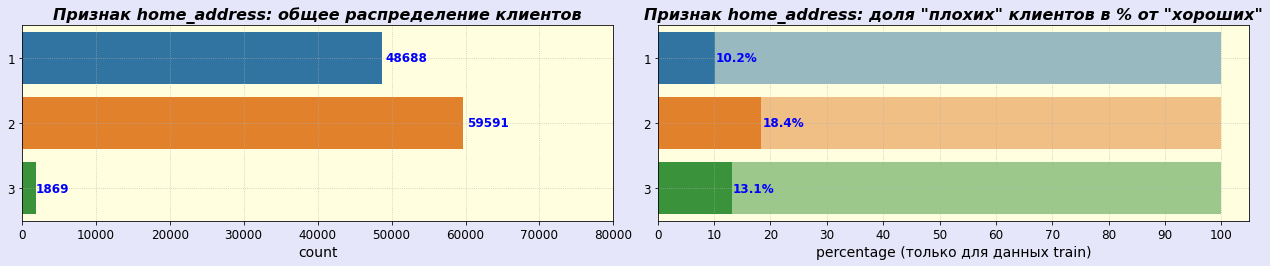

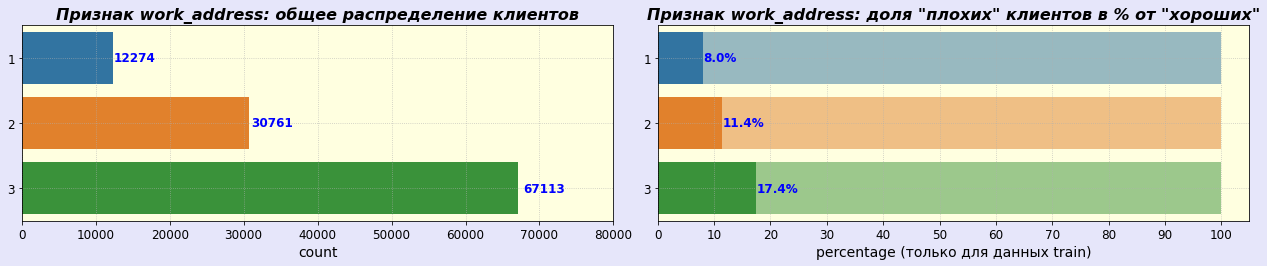

In [31]:
#------------------------------------------------------------------------------#
# Признак home_address:
print('=== home_address ===')
df = data.copy()
df.home_address = df.home_address.replace({1: '1', 2: '2', 3: '3'})
col = 'home_address'; cat_order = ['1', '2', '3']
df_tot, df_trg = get_simple_graph(df, col, cat_order)
ax = plt.gcf().get_axes(); ax[0].set_xlim([0, 80_000])
ax[1].set_xticks(range(0, 110, 10))
display(df_tot); display(df_trg)
# Признак work_address:
print('=== work_address ===')
df = data.copy()
df.work_address = df.work_address.replace({1: '1', 2: '2', 3: '3'})
col = 'work_address'; cat_order = ['1', '2', '3']
df_tot, df_trg = get_simple_graph(df, col, cat_order)
ax = plt.gcf().get_axes(); ax[0].set_xlim([0, 80_000])
ax[1].set_xticks(range(0, 110, 10))
display(df_tot); display(df_trg)

Общий вывод по признакам `home_address` и `work_address`. Нет ясности, по какому критерию осуществлена категоризация признаков. Единственное, что подсказывает "житейская логика", критерием могло быть расстояние от центра города. Признак `work_address` в этом случае позволяет сориентироваться в категориях. В работе [1] показано, что наибольшей ёмкостью рабочих мест обладает "центр" города:
>_"В группу районов с наиболее высокой обеспеченностью рабочими местами входят почти все муниципалитеты центра и значительная часть субцентральных
районов"_.

Впрочем, авторы статьи делят Москву на пять (а не на три) категорий:
>_"Типология муниципальных районов Москвы, проведенная методом кластерного анализа по наиболее важным показателям, характеризующим состояние локальных рынков труда на основе данных операторов сотовой связи по передвижениям внутригородских (в пределах Москвы) и межрегиональных (между Москвой и Московской областью) трудовых маятниковых мигрантов, позволила выделить пять типов агрегированных групп"_.

Для нас важно, что именно центр города является районом-"аттрактором", он даёт наибольшее количество рабочих мест в расчёте на количество локального трудоспособного населения. График для признака `work_address` показывает, что категория 3 даёт наибольшее количество клиентов банка, т.е. категория 3 признака `work_address` соответствует "центру" города. Тогда можно предположить, что категории 2 и 1 обозначают "промежуточные" и "спальные" районы соответственно:
* `work_address` = 1 - "спальные" районы (включая ближайший "загород")
* `work_address` = 2 - "промежуточные" районы
* `work_address` = 3 - "центр" города

Формально, в отсутствие прямой информации, у нас нет гарантий, что категоризация признака `home_address` проведена таким же образом. Однако "житейская логика" в виде бритвы Оккама подсказывает, что дело делали люди и вряд ли им хотелось плодить лишние сущности. Поэтому примем, что категоризация признаков `work_address` и `home_address` осуществлена по одной схеме:
* `home_address` = 1 - "спальные" районы (включая ближайший "загород")
* `home_address` = 2 - "промежуточные" районы
* `home_address` = 3 - "центр" города

График для `home_address` показывает разумность такой классификации - видим наименьшее (1_869 человек) количество клиентов, проживающих в "центре" города. Большинство (59_591 человек) клиентов проживает в "периферийных" районах, и "спальники" не сильно отстают - 48_688 человек. Любопытно, что самые ответственные заёмщики - это клиенты, работающие на периферии. У них наименьший процент "плохих" клиентов (8%). Среди людей, работающих в "центре" города, 17.4% "плохих" от всех "центрально-работающих". Впрочем, в "центр" многие едут, там полная "каша-малаша".

[1] Махрова А. Г., Бочкарев А. Н. _Анализ локальных рынков труда через трудовые маятниковые миграции населения (на примере муниципальных образований Москвы)_ // Вестник Санкт-Петербургского университета. Науки о Земле. 2018. Т. 63. Вып. 1. С. 56–68. https://doi.org/10.21638/11701/spbu07.2018.104
***

#### 1.11. Признак **foreign_passport**.
Наличие ("Y") или отсутствие ("N") загранпаспорта. 

,type,count,percentage
0,Y,16427,14.9
1,N,93721,85.1


,default_no,default_yes,no : yes,"yes, % no"
foreign_passport,,,,
Y,10246,820,12.5,8.0
N,54181,8552,6.3,15.8


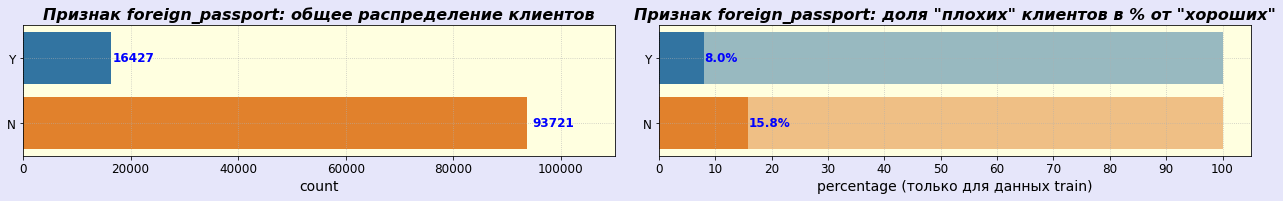

In [32]:
#------------------------------------------------------------------------------#
df = data.copy()
col = 'foreign_passport'; cat_order = ['Y', 'N']
df_tot, df_trg = get_simple_graph(df, col, cat_order)
ax = plt.gcf().get_axes(); ax[0].set_xlim([0, 110_000])
ax[1].set_xticks(range(0, 110, 10))
display(df_tot); display(df_trg)

Подавляющее большинство (85%) клиентов банка не имеют загранпаспорт. Отсюда следует, что банки неохотно кредитуют гастарбайтеров, коих в Москве насчитывается больше, чем во всех других мегаполисах России, вместе взятых. Ведь у гастарбайтера из Ближнего Зарубежья паспорт только один - иностранный.
Видим, что обладатели загранпаспортов являются более ответственными заёмщиками - 8% против 16%. Посмотрим распределение доходов для этих категорий.

INCOME:                     min  median    mean
foreign_passport default                       
N                0        1_000  30_000  37_002
                 1        3_700  25_450  34_390
Y                0        2_400  50_000  67_168
                 1        5_000  40_000  56_082

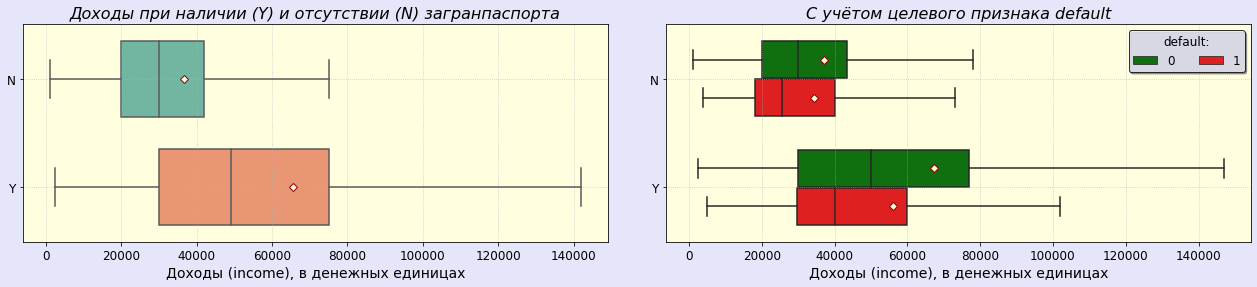

In [33]:
#------------------------------------------------------------------------------#
df = data.copy()
#---
fig, ax = plt.subplots(1, 2, figsize=(22, 4)); fig.subplots_adjust(wspace=0.1)
mean_props = dict(marker='D', markeredgecolor='DarkRed',
                  markerfacecolor='LightYellow')
sns.boxplot(data=df, x="income", y="foreign_passport", palette="Set2",
            showmeans=True, meanprops=mean_props, showfliers=False, width=0.7,
            ax=ax[0])
sns.boxplot(data=df[df.flag=="train"], x="income", y="foreign_passport",
            hue="default", showmeans=True, meanprops=mean_props,
            showfliers=False, width=0.7, ax=ax[1], palette=["g", "r"])
#---
[axs.set_xlabel('Доходы (income), в денежных единицах') for axs in ax]
[axs.grid("both") for axs in ax]
ax[0].set_title('Доходы при наличии (Y) и отсутствии (N) загранпаспорта',
             style='italic')
ax[0].set_ylabel('')
#---
ax[1].legend(loc="upper right", ncol=2, title="default:"); ax[1].set_ylabel('')
ax[1].set_title('С учётом целевого признака default', style='italic');
#------------------------------------------------------------------------------#
dff = df[df.flag=='train'].groupby(['foreign_passport', 'default']).income.agg(
                                                    ['min', 'median', 'mean'])
for col in dff.columns: dff[col] = dff[col].apply('{:_.0f}'.format)
display(dff.rename_axis("INCOME:", axis=1))

Как и ожидалось, доходы клиентов с загранпаспортом заметно превосходят оные у клиентов без загранпаспорта. Учёт целевого признака `default` показывает ещё более сильное различие в доходах "хороших" клиентов с загранпаспортом (нижний зелёный "ящик") и "плохих" клиентов без загранпаспорта (верхний красный "ящик").
***

#### 1.12. Признак **sna**.
Cвязь заемщика с клиентами банка. О какой связи идёт речь? Предположим, что - о родственной. Я не специалист в банковских делах, но "житейская логика" подсказывает, что если в семье кредит берут два, три и более членов семьи, долговая нагрузка на семью становится большой, что может увеличить риск дефолта.

In [34]:
data.sna.value_counts(sort=False)

1    70681
2    15832
3     6154
4    17481
Name: sna, dtype: int64

,type,count,percentage
0,1,70681,64.2
1,2,15832,14.4
2,3,6154,5.6
3,4,17481,15.9


,default_no,default_yes,no : yes,"yes, % no"
sna,,,,
1,42656,4645,9.2,10.9
2,9034,1592,5.7,17.6
3,3473,650,5.3,18.7
4,9264,2485,3.7,26.8


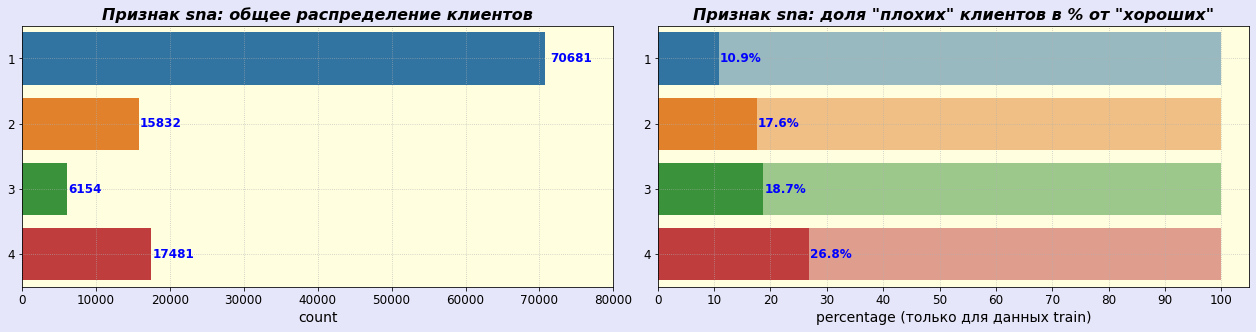

In [35]:
#------------------------------------------------------------------------------#
df = data.copy()
df.sna = df.sna.replace({1: '1', 2: '2', 3: '3', 4: '4'})
col = 'sna'; cat_order = ['1', '2', '3', '4']
df_tot, df_trg = get_simple_graph(df, col, cat_order)
ax = plt.gcf().get_axes(); ax[0].set_xlim([0, 80_000])
ax[1].set_xticks(range(0, 110, 10))
display(df_tot); display(df_trg)

Видим, что наибольшее количество клиентов (64.2%) относятся к категории 1 признака `sna`. При этом доля "плохих" клиентов в данной категории самая низкая (11%). По мере увеличения категории растёт и доля "плохих" клиентов, достигая максимальной величины в 27% для категории 4. Каждый четвёртый клиент категории 4 является "плохим"...

INCOME:        min  median    mean
sna default                       
1   0        1_000  30_000  44_457
    1        4_000  30_000  38_619
2   0        2_400  30_000  40_098
    1        3_700  30_000  35_109
3   0        5_000  30_000  36_044
    1        5_000  27_675  34_613
4   0        1_000  25_000  33_381
    1        4_500  25_000  33_125

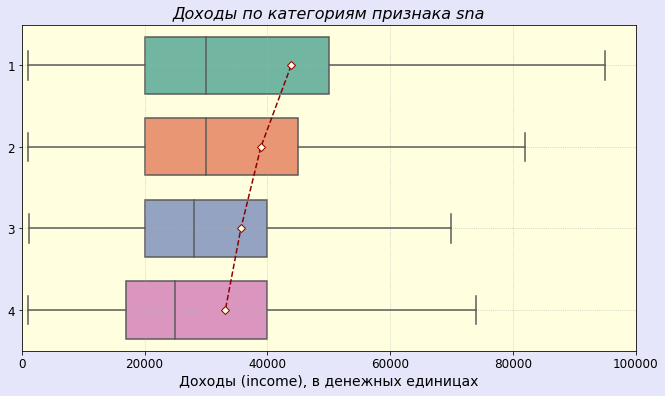

In [36]:
#------------------------------------------------------------------------------#
df = data.copy()
df.sna = df.sna.replace({1: '1', 2: '2', 3: '3', 4: '4'})
#---
fig, ax = plt.subplots(figsize=(11, 6))
mean_props = dict(marker='D', markeredgecolor='DarkRed',
                  markerfacecolor='LightYellow')
sns.boxplot(data=df, x="income", y="sna", palette="Set2", showmeans=True,
            meanprops=mean_props, showfliers=False, width=0.7, order=cat_order)
#---
x_val = [df[df.sna==k].income.mean() for k in cat_order]
y_val = [k for k,_ in enumerate(cat_order)]
ax.plot(x_val, y_val, color="DarkRed", ls="--")
#---
ax.set_xlabel('Доходы (income), в денежных единицах'); ax.grid("both")
ax.set_title('Доходы по категориям признака sna', style='italic')
ax.set_ylabel(''); ax.set_xlim(0, 100_000)
#------------------------------------------------------------------------------#
dff = df[df.flag=='train'].groupby(['sna', 'default']).income.agg(
                                                    ['min', 'median', 'mean'])
for col in dff.columns: dff[col] = dff[col].apply('{:_.0f}'.format)
display(dff.rename_axis("INCOME:", axis=1))

Средняя величина доходов снижается с увеличением категории признака `sna`. Учитывая рост вероятности дефолта с увеличением количества родственников, взявших кредит, в голову приходит только одна мысль - "дурной пример заразителен".
***

#### 1.13. Признак **first_time**.
Давность наличия информации о заемщике. Категориальный признак.

In [37]:
data.first_time.value_counts(sort=False)

1    18296
2    17247
3    46588
4    28017
Name: first_time, dtype: int64

Четыре категории давности. Что они могут значить?

,type,count,percentage
0,1,18296,16.6
1,2,17247,15.7
2,3,46588,42.3
3,4,28017,25.4


,default_no,default_yes,no : yes,"yes, % no"
first_time,,,,
1,9961,2278,4.4,22.9
2,9770,1798,5.4,18.4
3,27496,3759,7.3,13.7
4,17200,1537,11.2,8.9


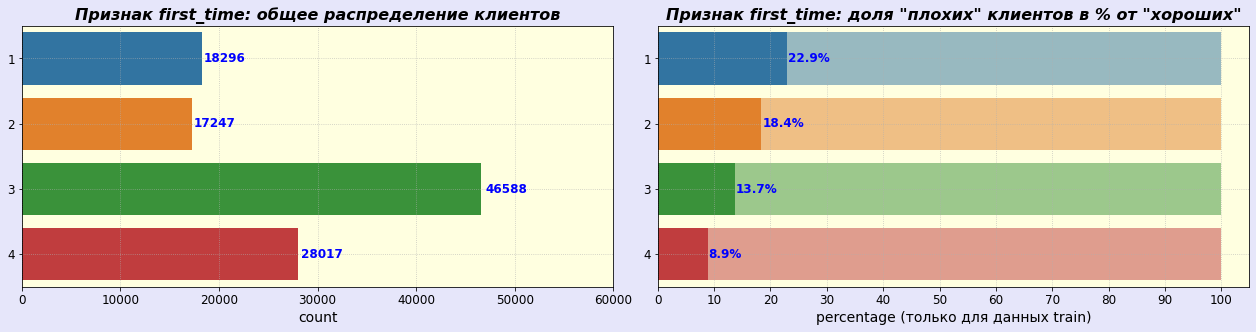

In [38]:
#------------------------------------------------------------------------------#
df = data.copy()
df.first_time = df.first_time.replace({1: '1', 2: '2', 3: '3', 4: '4'})
col = 'first_time'; cat_order = ['1', '2', '3', '4']
df_tot, df_trg = get_simple_graph(df, col, cat_order)
ax = plt.gcf().get_axes(); ax[0].set_xlim([0, 60_000])
ax[1].set_xticks(range(0, 110, 10))
display(df_tot); display(df_trg)

Наблюдается чётко выраженная тенденция - с увеличением номера категории уменьшается доля "плохих" клиентов. Так, для категории 1 имеем наибольших процент "плохих" клиентов (22.9%), а для категории 4 - наименьший (8.9%). При этом категория 3 представлена наибольшим количеством клиентов (46 588 человек или 42.3% от всех клиентов в датасете).
***

#### 1.14. Признак **app_date**.
Дата подачи заявки. По-видимому, имеет смысл даты подачи _последней_ заявки.

In [39]:
data.app_date.head(7)

0    01FEB2014
1    12MAR2014
2    01FEB2014
3    23JAN2014
4    18APR2014
5    18FEB2014
6    04FEB2014
Name: app_date, dtype: object

In [40]:
data.app_date.value_counts()

18MAR2014    1491
19MAR2014    1363
17MAR2014    1350
31MAR2014    1317
07APR2014    1296
             ... 
20APR2014     359
07JAN2014     349
03JAN2014     313
02JAN2014     204
01JAN2014      56
Name: app_date, Length: 120, dtype: int64

Признак является объектом date. Попробуем раздербанить его на составлные части - год, месяц, день месяца.

In [41]:
df = data.copy()
df.app_date = pd.to_datetime(df.app_date)
df.app_date.value_counts()

2014-03-18    1491
2014-03-19    1363
2014-03-17    1350
2014-03-31    1317
2014-04-07    1296
              ... 
2014-04-20     359
2014-01-07     349
2014-01-03     313
2014-01-02     204
2014-01-01      56
Name: app_date, Length: 120, dtype: int64

In [42]:
# Годы:
df.app_date.dt.year.value_counts()

2014    110148
Name: app_date, dtype: int64

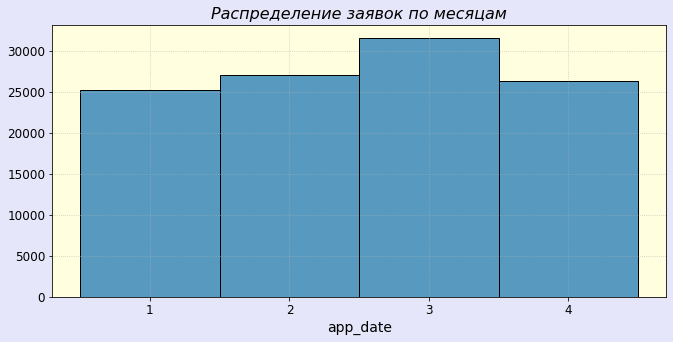

In [43]:
# Месяцы:
df.app_date.dt.month.value_counts(sort=False)
sns.histplot(x=df.app_date.dt.month, discrete=True);
fig, ax = plt.gcf(), plt.gca()
fig.set_size_inches(11, 5)
ax.set_xticks(range(1,5));
ax.set_ylabel('')
ax.set_title("Распределение заявок по месяцам", style="italic");

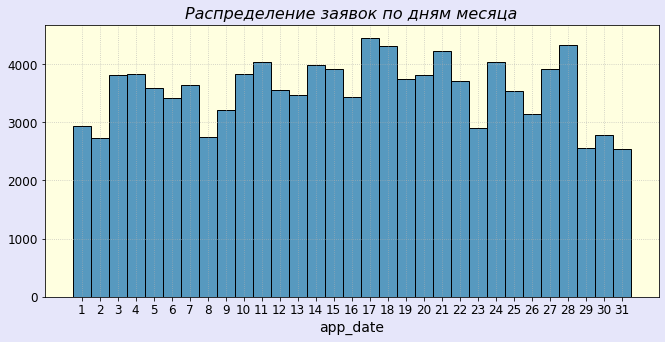

In [44]:
# Дни месяца:
sns.histplot(x=df.app_date.dt.day, discrete=True);
fig, ax = plt.gcf(), plt.gca()
fig.set_size_inches(11, 5)
ax.set_xticks(range(1,32)); ax.set_ylabel('')
ax.set_title("Распределение заявок по дням месяца", style="italic");

Все данные относятся к первым четырём месяцам 2014-го года. Среди месяцев несколько выделяется март. Что же касается дней месяца, видим провалы на некоторых днях, которые можно попытаться объяснить "житейской логикой":
* Провалы на 1-ом и 2-ом днях - ну, видимо, обусловлены отмечанием Нового Года, а также выходными днями (1-ое и 2-ое числа февраля 2014-го года - это суббота и воскресенье)
* Провал на 8-ом дне вызван, наверное, празднованием Международного женского дня, - как и провал на 23 числе (День защитника Отечества)
* Последние три дня - 29, 30, 31 - их нет в феврале (2014 - невисокосный год). Кроме того, 31-ый день месяца встречается только два раза из четырёх месяцев. А вообще, 31-ое число месяца встречается в году только 7 раз из 12-ти...
***

#### 1.15. Признак **score_bki** и **region_rating**. 
* score_bki - скоринговый балл по данным из БКИ
* region_rating - рейтинг региона

In [45]:
data[['score_bki', 'region_rating']].describe().T

,count,mean,std,min,25%,50%,75%,max
score_bki,110148.0,-1.904535,0.499397,-3.624586,-2.260434,-1.920823,-1.567888,0.199773
region_rating,110148.0,56.751189,13.065923,20.000000,50.000000,50.000000,60.000000,80.000000


In [46]:
data[['score_bki', 'region_rating']].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110148 entries, 0 to 110147
Data columns (total 2 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   score_bki      110148 non-null  float64
 1   region_rating  110148 non-null  int64  
dtypes: float64(1), int64(1)
memory usage: 1.7 MB


In [47]:
data.region_rating.value_counts().sort_index()

20      313
30      434
40    17947
50    40981
60    23999
70     9304
80    17170
Name: region_rating, dtype: int64

Признак `region_rating` является категориальным (целочисленным, семь категорий), `score_bki` - числовым.

,type,count,percentage
0,20,313,0.3
1,30,434,0.4
2,40,17947,16.3
3,50,40981,37.2
4,60,23999,21.8
5,70,9304,8.4
6,80,17170,15.6


,default_no,default_yes,no : yes,"yes, % no"
region_rating,,,,
20,162,44,3.7,27.2
30,243,57,4.3,23.5
40,9986,2041,4.9,20.4
50,23776,3747,6.3,15.8
60,14004,2071,6.8,14.8
70,5626,573,9.8,10.2
80,10630,839,12.7,7.9


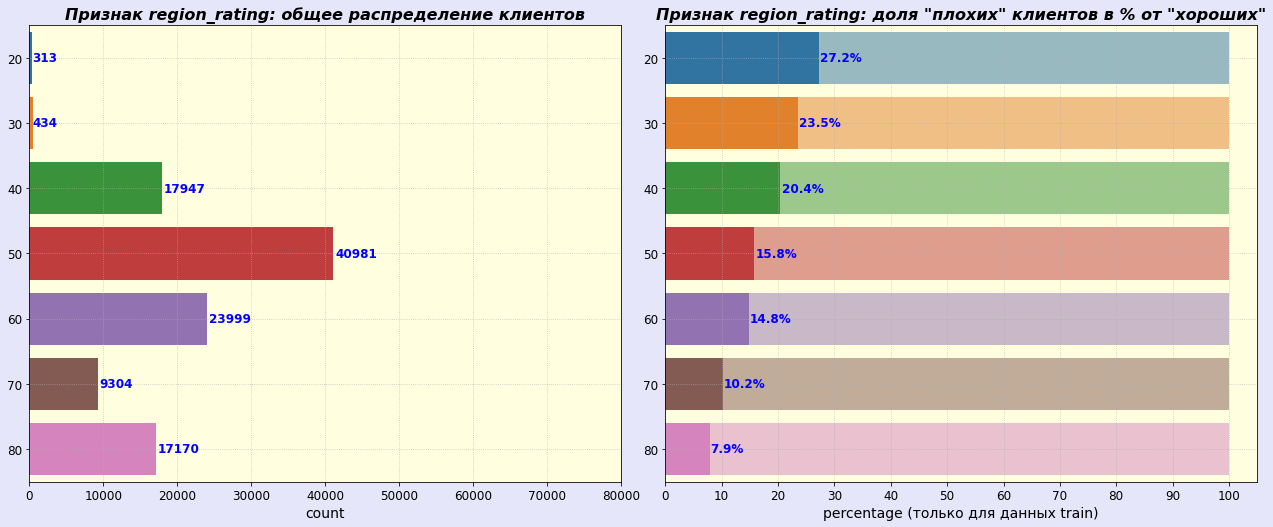

In [48]:
#------------------------------------------------------------------------------#
# Признак region_rating:
df = data.copy()
cat_order = sorted(list(set(df.region_rating.values)))
dct = {k: str(k) for k in cat_order}
cat_order = [str(k) for k in cat_order]
df.region_rating = df.region_rating.replace(to_replace=dct)
col = 'region_rating'
df_tot, df_trg = get_simple_graph(df, col, cat_order)
ax = plt.gcf().get_axes(); ax[0].set_xlim([0, 80_000])
ax[1].set_xticks(range(0, 110, 10))
display(df_tot); display(df_trg)

Наблюдаемая ситуация с признаком `region_rating` внушает уважение к методике расчёта рейтинга регионов: действительно, чем выше рейтинг, тем ниже доля "плохих" клиентов из данного региона...

Коэффициенты:
	- асимметрии: 0.194
	- эксцесса:  -0.149


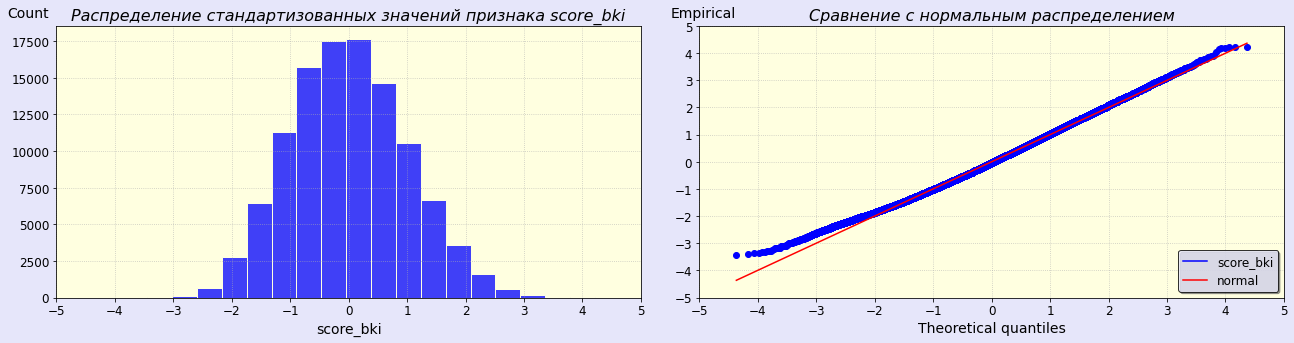

In [49]:
#------------------------------------------------------------------------------#
# Признак score_bki:
df = data.copy()
# Стандартизуем для удобства:
df.score_bki = (df.score_bki - df.score_bki.mean())/df.score_bki.std()
#---
fig, ax = plt.subplots(1, 2, figsize=(22, 5)); fig.subplots_adjust(wspace=0.1)
sns.histplot(data=df, x="score_bki", bins='sturges', ax=ax[0], color="blue",
             ec="lightyellow");
stats.probplot(df.score_bki, plot=ax[1]);
#---
ax[0].set_ylabel('Count', rotation=0, position=(0., 1.02), ha="left")
ax[0].set_title('Распределение стандартизованных значений признака score_bki',
                style="italic");
ax[0].set_xticks(range(-5, 6, 1))
#---
blue_line = mlines.Line2D([], [], color='blue', label='score_bki')
red_line = mlines.Line2D([], [], color='red', label='normal')
ax[1].legend(handles=[blue_line, red_line], loc="lower right")
ax[1].set_title('Сравнение с нормальным распределением', style="italic");
ax[1].set_ylabel('');
ax[1].set_ylabel('Empirical', rotation=0, position=(0., 1.02), ha="left")
ax[1].set_xticks(range(-5, 6, 1)); ax[1].set_yticks(range(-5, 6, 1));
#---
sk = df.score_bki.skew()
kurt = df.score_bki.kurtosis()
print(f'Коэффициенты:\n\t- асимметрии: {sk:5.3f}\n\t- эксцесса: {kurt:7.3f}')

Распределение признака `score_bki` близко к нормальному. Только на "малых" квантилях наблюдается "скукоживание" - левая ветвь распределения более короткая, нежели правая, т.е. имеет место асимметрия. Кроме того, имеет место отрицательный эксцесс, т.е. распределение признака является более "плоским", нежели нормальное распределение.
***

### Выводы по Разделу 1. Знакомство с данными.
* Исходный датасет состоит из двух частей train и test. Часть train используется для обучения модели, а часть test нужна для определения предсказательной силы модели. Часть test впоследствии отправляется на kaggle под видом submission в виде отчёта по проекту.
* Данные train и test объединены в одну таблицу данных, которая состоит из 110_148 объектов наблюдений (строки) и 20 признаков (колонки). При этом колонки `client_id` и `flag` имеют исключительно служебный характер. Целевым является признак `default`, имеющий две категории:
    * default = 1 - "плохие" клиенты, допустившие дефолт по кредиту
    * default = 0 - "хорошие" клиенты, не создавшие проблем
* Наличествует дисбаланс классов: соотношение "хорошие" клиенты / "плохие клиенты = 6.9 / 1, т.е. "хороших" клиентов в 7 раз больше, чем "плохих".
* Пропуски данных имеют место в одном признаке `education` в количестве 478 штук, или 0.4%. В остальных признаках пропусков нет.
* Числовые признаки `income`, `age`, `decline_app_cnt` и `bki_request_cnt` имеют тяжёлый правый хвост, их эмпирические функции распределения далеки от нормального закона. Признак `score_bki` близок к нормальному.
* Обнаружено смысловое противоречие в признаках `decline_app_cnt` и `bki_request_cnt`.


In [50]:
# Числовые признаки:
num_cols = ['age', 'decline_app_cnt', 'income', 'bki_request_cnt', 'score_bki']
# Категориальные бинарные признаки:
bin_cols = ['sex', 'car', 'car_type', 'foreign_passport', 'good_work']
# Категориальные небинарные признаки:
cat_cols = ['education', 'home_address', 'work_address', 'sna', 'first_time', 'region_rating']
# Признаки даты:
date_cols = ['app_date']
#---
print(len(num_cols) + len(bin_cols) + len(cat_cols) + len(date_cols))
print(data.shape[1] - 3) # За вычетом client_id, flag и default

17
17
